# The open food repo

## Project 2: Tasks A-B

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json, pickle
from scipy.stats import zscore

import matplotlib.cm as cm
COLOR_1 = cm.get_cmap("Set2")(2) # set blue for train
COLOR_2 = cm.get_cmap("Set2")(1) # set orange for test

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run tools.py

The dataset contains the following information for each food product ([source](https://github.com/digitalepidemiologylab/foodrepo_api/blob/master/v3/schema/product.md)):

* id: The ID used by the OpenFood database for this Product.
* barcode: Product barcode.
* ingredients_en: The ingredients of the Product in English as provided by the manufacturer.
* quantity: The dry net weight or volume of the Product. To be used in conjunction with the unit.
* unit: The unit used by quantity to measure the weight or volume of the Product. Usually g or ml.
* portion_quantity: The dry net weight or volume of a serving size of the Product. To be used in conjunction with portion_unit.
* portion_unit: The unit used by portion_quantity to measure the weight or volume of a serving size of the Product. Usually g or ml.
* hundred_unit: The unit used for the “per hundred” product nutrients (Usually g or ml).
* alcohol_by_volume: The percentage of alcohol in the Product.
* nutrients: The Product’s Nutrients as described by the manufacturer.
* created_at: UTC DateTime at which this Product was added to the OpenFood database.
* updated_at: UTC DateTime at which this Product (or one of its subordinate objects, including images nutrients) was last modified.

# Task A. An overview of the dataset

### Task A.1 

> Import the data as a pandas DataFrame into your notebook.

In [34]:
# Load the data

# Source: https://pandas.pydata.org/docs/reference/api/pandas.read_pickle.html
df_raw = pd.read_pickle("./data/data_385k.pkl", compression='zip')

In [54]:
numeric_df = df_raw[df_raw.columns.difference(['id'])].select_dtypes(include=np.number)
categoric_df = df_raw[df_raw.columns.difference(['id'])].select_dtypes(exclude=np.number)

col_per_hundred = [col for col in numeric_df.columns if 'per_hundred' in col]
col_per_portion = [col for col in numeric_df.columns if 'per_portion' in col]
col_unit = [col for col in categoric_df.columns if '_unit' in col]
col_other = df_raw.columns.difference(col_per_hundred+col_per_portion+col_unit).to_list()

print(df_raw.shape[1], 
      len(col_per_hundred), 
      len(col_per_portion), 
      len(col_unit), 
      len(col_other))


99 37 10 39 13


### Task A.2 

> Check the number of rows and columns. You should have 385’384 samples and 99 columns.

In [37]:
print(df_raw.shape)

(385384, 99)


### Task A.3 

> Display a few entries from the DataFrame.

In [38]:
df_raw.sample(3)

,alcohol_by_volume,barcode,calcium_per_hundred,calcium_unit,carbohydrates_per_hundred,carbohydrates_per_portion,carbohydrates_unit,cholesterol_per_hundred,cholesterol_unit,copper_cu_per_hundred,...,vitamin_b5_panthothenic_acid_per_hundred,vitamin_b5_panthothenic_acid_unit,vitamin_b6_pyridoxin_per_hundred,vitamin_b6_pyridoxin_unit,vitamin_c_ascorbic_acid_per_hundred,vitamin_c_ascorbic_acid_unit,vitamin_d_d2_d3_international_units_per_hundred,vitamin_d_d2_d3_international_units_unit,zinc_per_hundred,zinc_unit
132010,0.0,0883967384044,100.0,mg,70.00,NaN,g,0.0,mg,NaN,...,NaN,NaN,NaN,NaN,3.0,mg,NaN,NaN,NaN,NaN
169676,0.0,0794504099706,59.0,mg,29.41,NaN,g,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15040,0.0,8711000503034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Task A.4 

> Check the data type for each column. Create separate lists to hold the names of columns of the same data type.

In [40]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385384 entries, 0 to 385383
Data columns (total 99 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   alcohol_by_volume                                385384 non-null  float64
 1   barcode                                          385384 non-null  object 
 2   calcium_per_hundred                              264979 non-null  float64
 3   calcium_unit                                     265086 non-null  object 
 4   carbohydrates_per_hundred                        351551 non-null  float64
 5   carbohydrates_per_portion                        11480 non-null   float64
 6   carbohydrates_unit                               351828 non-null  object 
 7   cholesterol_per_hundred                          270282 non-null  float64
 8   cholesterol_unit                                 270329 non-null  object 
 9   copper_cu_per_h

In [42]:
# Create lists of categorical and numeric columns

cat_cols = df_raw.select_dtypes(exclude=np.number).columns.to_list()
num_cols = df_raw.select_dtypes(include=np.number).columns.to_list()

print('Found {} numeric columns.'.format(len(num_cols)))
print('Found {} categorical columns.'.format(len(cat_cols)))

Found 51 numeric columns.
Found 48 categorical columns.


# Task B. Preliminary Exploratory Data Analysis

### Task B.1 : Duplicated entries

> Are there any duplicated products in the data? Can you remove them? What is the shape of the DataFrame after removing duplicated products?

The ID used by the OpenFood database is a unique identifier for each product. We should have only unique ID numbers in the data, which isn't the case as we see below.

In [ ]:
df.id.nunique() == len(df)

In [ ]:
# Count duplicated entries

df.duplicated().sum()

In [ ]:
# Count duplicated entries in subset: numeric columns

df.duplicated(subset=num_cols).sum()

In [ ]:
# Drop duplicated entries

print('Before dropping duplicates: ',df.shape)
df.drop_duplicates(inplace=True)
print('After dropping duplicates: ',df.shape)

In [ ]:
df.id.nunique() == len(df)

Now the dataframe contains only unique ID numbers for each product.

### Tasks B.2 and B.3 : Missing values

> B.2: Check if there are missing values in the data. Given the number of columns in the dataset, you can use the lists of columns created in task A.5 to perform this analysis separately for numerical and categorical columns. Think about how to communicate your findings on missing values best (e.g., using appropriate visualizations and numerical summaries).
>
> B.3: Now that you know the extent of missing values in the data, you should address them. Your goal is to keep as much data as possible in your DataFrame. What is the shape of the DataFrame after addressing missing values?

We start by looking at missing values in all columns (i.e. both categorical and numeric columns).

In [32]:
# Sort columns by their non-null values

missing_values_table(df,df.columns)

NameError: name 'df' is not defined

We have many columns with missing data. Let's start with the categorical columns.

### Missing values in categorical columns

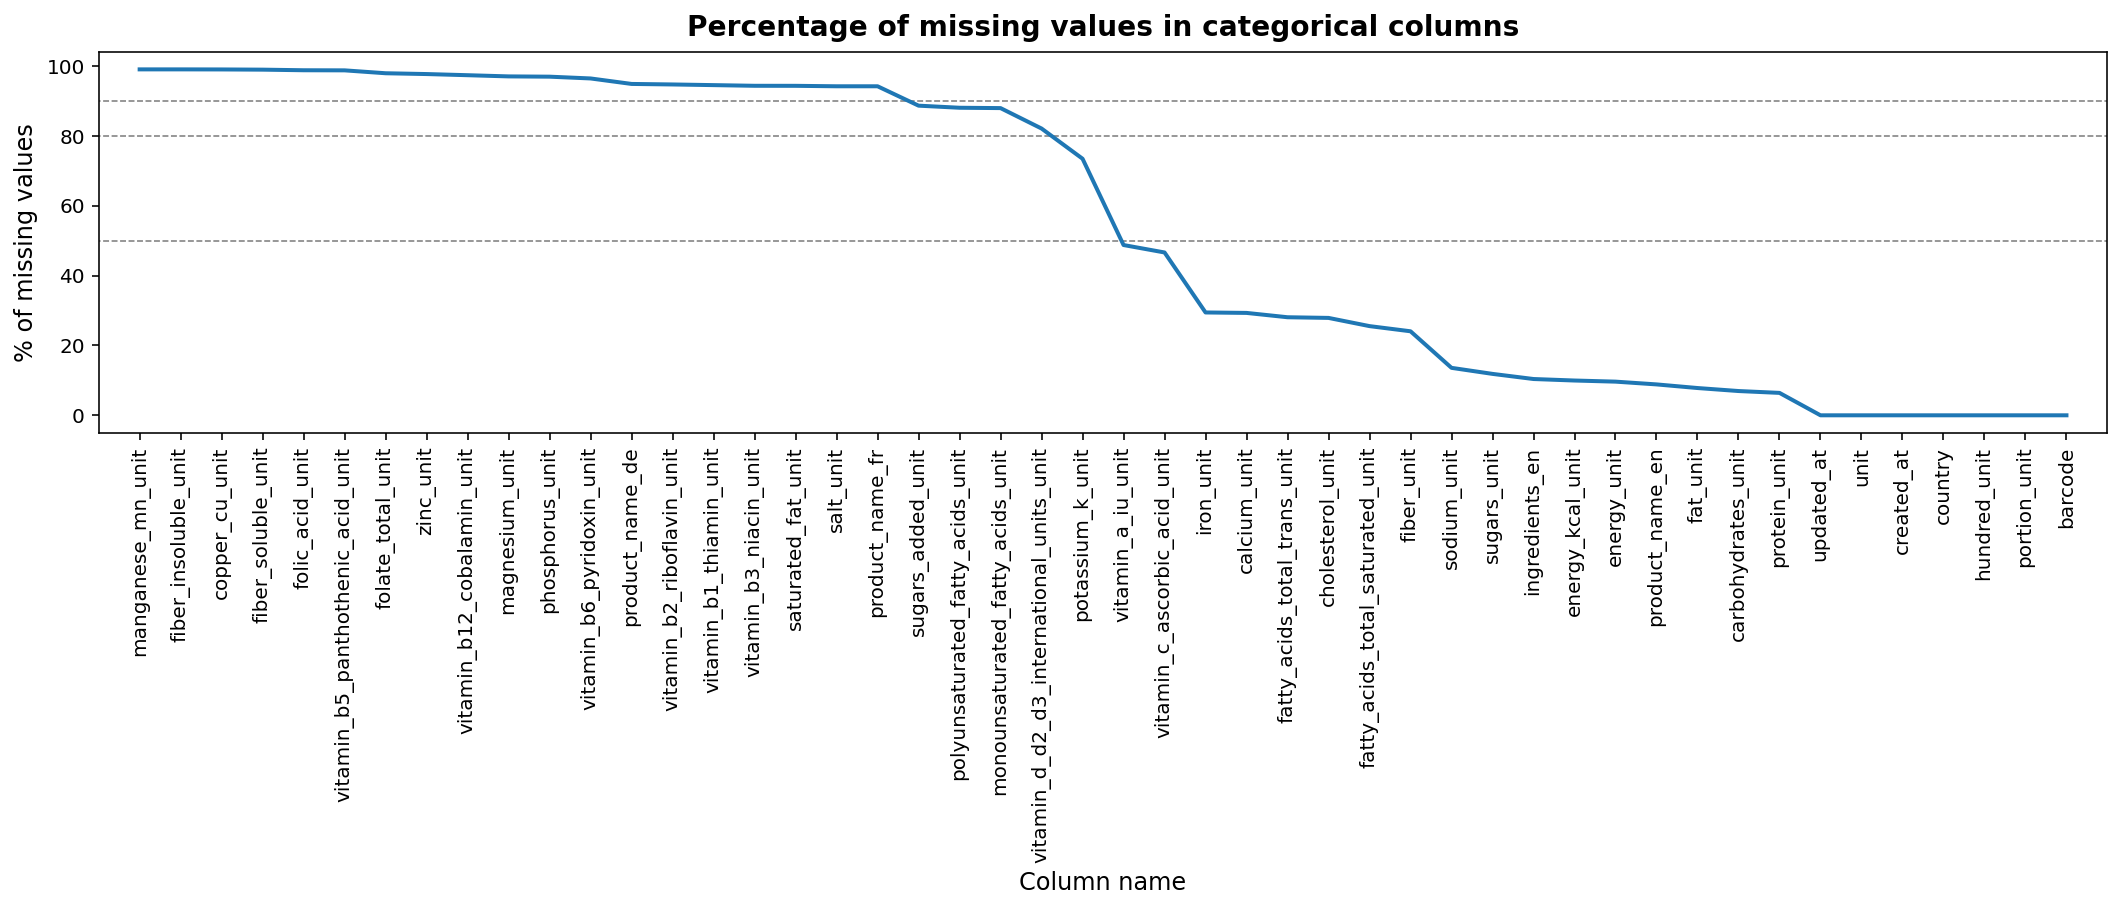

In [24]:
plot_missing_values(df,cat_cols,'categorical')

### Addressing missing values in categorical columns

Many values are missing in `_unit` columns. These missing values could be inferred easily from the non-null values in the same column.

In [25]:
# Create list of _unit columns
unit_cols_to_impute = [c for c in df[cat_cols].isnull().sum().index if '_unit' in c and 'portion' not in c and 'hundred' not in c]

# Impute missing values in _unit columns
for c in unit_cols_to_impute:
    df.fillna(value = {c:df[c].mode()[0]},inplace=True)
    try:
        df[c].nunique() == 1
    except:
        print(c, df[c].unique())
        continue

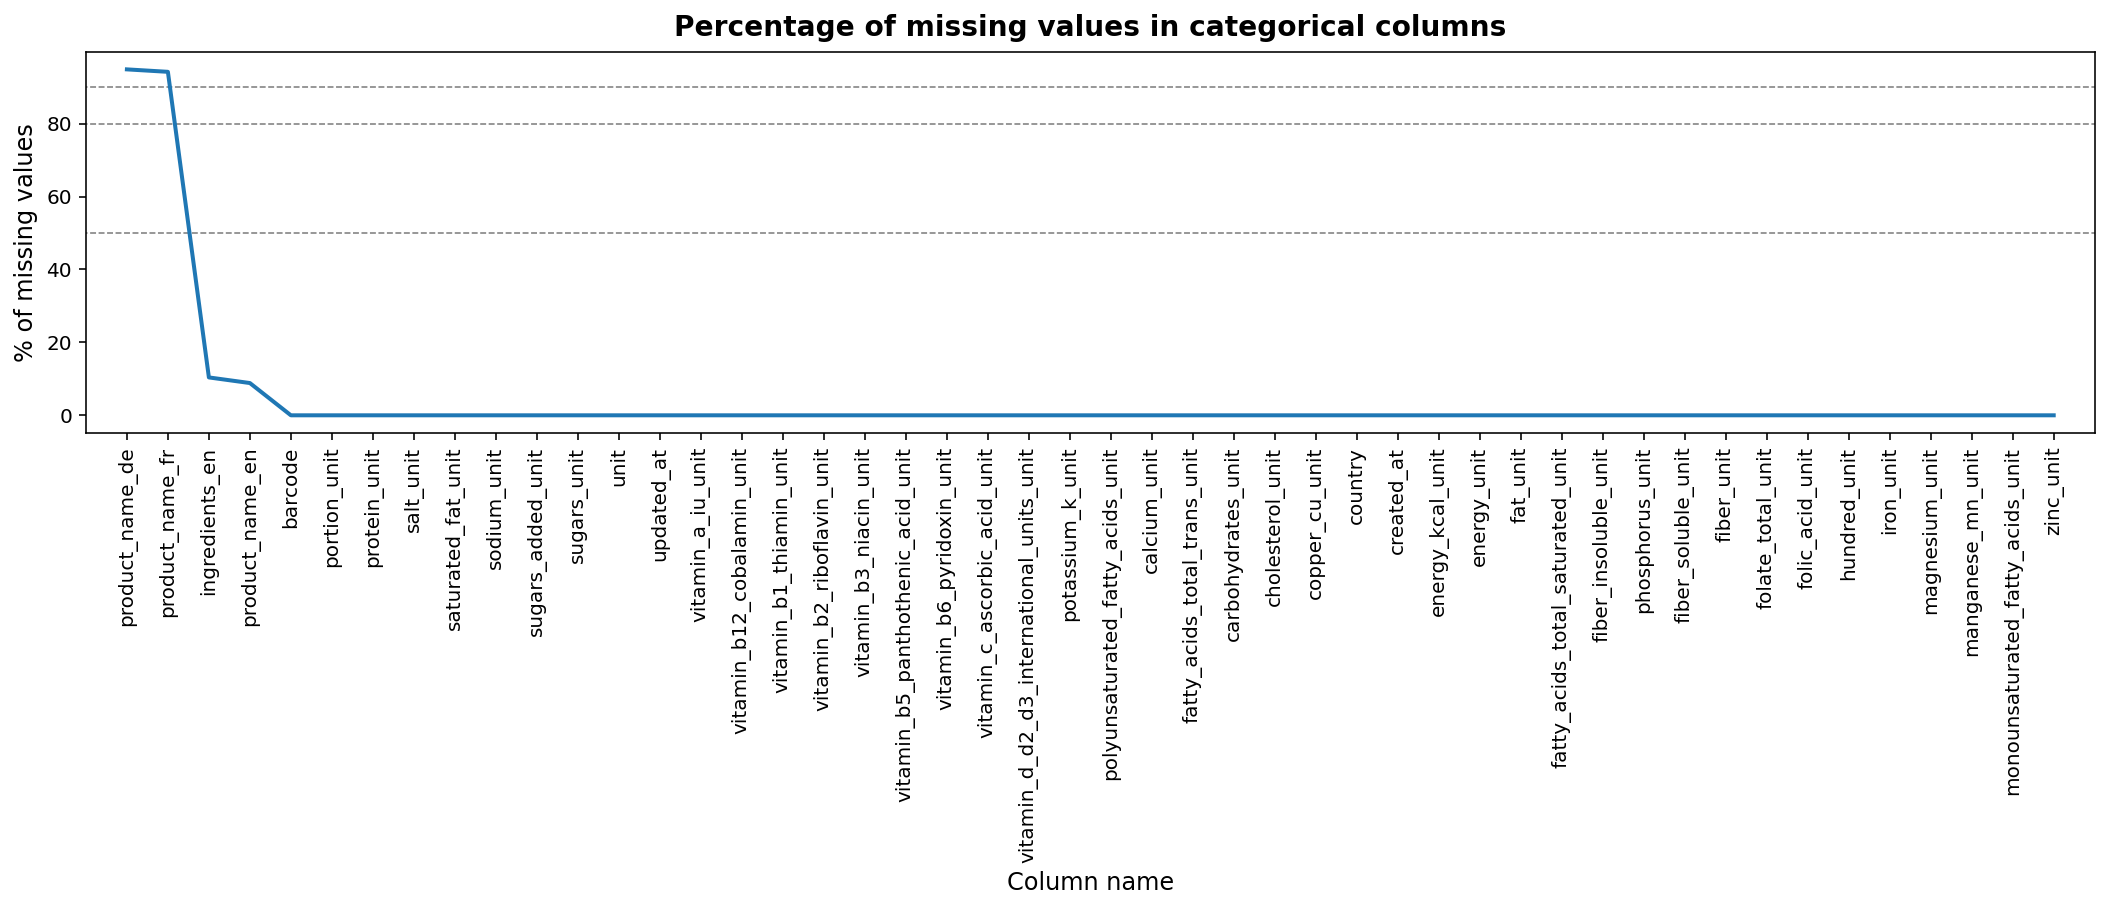

In [26]:
# Re-Plot percentage of missing data in categorical data

plot_missing_values(df,cat_cols,'categorical')

The remaining missing values are in the product_name and the ingredients columns.

In [27]:
# Sort categorical columns by their non-null values

missing_values_table(df,cat_cols)

,NaNs,non_NaNs,NaNs_perc,dtype
columns,,,,
product_name_de,355736,19148,94.9,object
product_name_fr,353199,21685,94.2,object
ingredients_en,38958,335926,10.4,object
product_name_en,33165,341719,8.8,object


The `product_name_en` and `ingredients_en` columns are the ones with the least missing values, which is good news as we would like to work with the "english" versions of these columns.

Below, we replace the missing values in `product_name_en` using the values in `product_name_fr` and `product_name_de` (whenever possible).

In [28]:
# Look whether product name is available in FR
df.loc[(df['product_name_en'].isnull()) & (df['product_name_fr'].notnull()),['product_name_en','product_name_fr']]

,product_name_en,product_name_fr
5,NaN,Cailler - Poudre de cacao
16,NaN,Naturaplan : Farine multi-céréales
18,NaN,"naturaplan : Framboises, confiture"
26,NaN,OPALINE : ABRCOTS
27,NaN,OPALINE : POMMES ET FRAMBOISES
...,...,...
374867,NaN,M Classic - Yogourt (Noisette)
374877,NaN,Party - Arachides (grillées et salées)
374878,NaN,falafel (patate douce)
374880,NaN,Bourquin nutrition - Boisson d'effort (Goût ci...


When the `product_name_en` is missing, then it is available in the `product_name_fr` column 11'619 times.

In [29]:
# If product_name in EN is missing, replace with product_name in FR (when possible)
df['product_name_en'] = pd.Series(np.where(df['product_name_en'].isnull(),df['product_name_fr'],df['product_name_en']))
print('Nbr of missing values remaining in product_name_en: ',df['product_name_en'].isnull().sum())

Nbr of missing values remaining in product_name_en:  21546


In [30]:
# If product_name in EN is missing, replace with product_name in DE  (if possible)
df['product_name_en'] = pd.Series(np.where(df['product_name_en'].isnull(),df['product_name_de'],df['product_name_en']))
print('Nbr of missing values remaining in product_name_en: ',df['product_name_en'].isnull().sum())

Nbr of missing values remaining in product_name_en:  18866


Cleaning steps implemented below:
* I will remove the columns: `product_name_fr`, `product_name_de` as I no longer need them.
* Drop rows where the `product_name_en` is missing
* Rename `product_name_en` to `product_name` for convenience.

In [31]:
# Remove product_name cols if not in english

cols_to_remove = ['product_name_fr', 'product_name_de']

print('Before dropping columns',df.shape)

df.drop(labels = cols_to_remove,
        axis=1,
        inplace=True)

print('After dropping columns',df.shape)
print()

# Remove rows where the product_name_en is missing
print('Before removing rows with missing product_name:',df.shape)
df = df.loc[df['product_name_en'].notnull(),:].copy() 
df.reset_index(inplace=True,drop=True)

# Rename product_name_en column to product_name (for convenience)
df.rename(columns={"product_name_en": "product_name"},
         inplace=True)

print('After removing rows with missing product_name:',df.shape)
print()
# Update list of categorical columns
cat_cols = df.select_dtypes(exclude=np.number).columns.to_list()
print('Found {} categorical columns.'.format(len(cat_cols)))

Before dropping columns (374884, 99)
After dropping columns (374884, 97)

Before removing rows with missing product_name: (374884, 97)
After removing rows with missing product_name: (356018, 97)

Found 46 categorical columns.


In [32]:
# Sort columns by their non-null values

missing_values_table(df,cat_cols)

,NaNs,non_NaNs,NaNs_perc,dtype
columns,,,,
ingredients_en,20303,335715,5.7,object


In categorical values, we now have missing values only in the `ingredients_en` column. Let's have a look at a few samples with missing values in the `ingredients_en` column.

In [33]:
df.loc[df['ingredients_en'].isnull(),['product_name','ingredients_en','barcode']]

,product_name,ingredients_en,barcode
11,Rythm 108 - banana muffin,NaN,7640155340014
12,Naturaplan Apricot Jam,NaN,7610849101801
16,Naturaplan : Farine multi-céréales,NaN,7610803008085
18,"naturaplan : Framboises, confiture",NaN,7610849101818
26,OPALINE : ABRCOTS,NaN,7640158540305
...,...,...,...
356012,"Brown rice, pumpkin & ginger noodle",NaN,0619286609007
356013,Party - Arachides (grillées et salées),NaN,7613312207277
356014,falafel (patate douce),NaN,7640158181492
356015,Nutriathletic - Whey (Swiss chocolate flavour),NaN,7640145040283


After some simple checks on the open food repo, it seems that for most of these products, the ingredients list in available in other languages, but not in english. I can impute missing values in these columns with this string `not_available_in_en`.

In [34]:
# Replace missing values in column `ingredients_en`

df['ingredients_en'].fillna(value = 'not_available_in_en',inplace=True)

In [35]:
# Recount missing values in categorical columns

df[cat_cols].isnull().sum().sum()

0

In [36]:
# Lowercase categorical columns

df['ingredients_en'] = df['ingredients_en'].str.lower()
df['product_name']   = df['product_name'].str.lower()

### Missing values in numeric columns

Let's have a look at the missing values in numeric columns.

In [37]:
# Sort numeric columns by their non-null values

missing_values_table(df,num_cols)

,NaNs,non_NaNs,NaNs_perc,dtype
columns,,,,
sodium_per_portion,355298,720,99.8,float64
fiber_insoluble_per_hundred,352509,3509,99.0,float64
manganese_mn_per_hundred,352484,3534,99.0,float64
copper_cu_per_hundred,352407,3611,99.0,float64
fiber_soluble_per_hundred,352191,3827,98.9,float64
folic_acid_per_hundred,351572,4446,98.8,float64
vitamin_b5_panthothenic_acid_per_hundred,351493,4525,98.7,float64
fiber_per_portion,348762,7256,98.0,float64
folate_total_per_hundred,348322,7696,97.8,float64


There are many numeric columns, so it's hard to have an overview of the % of missing values. Better to plot the percentage of missing values in numeric data.

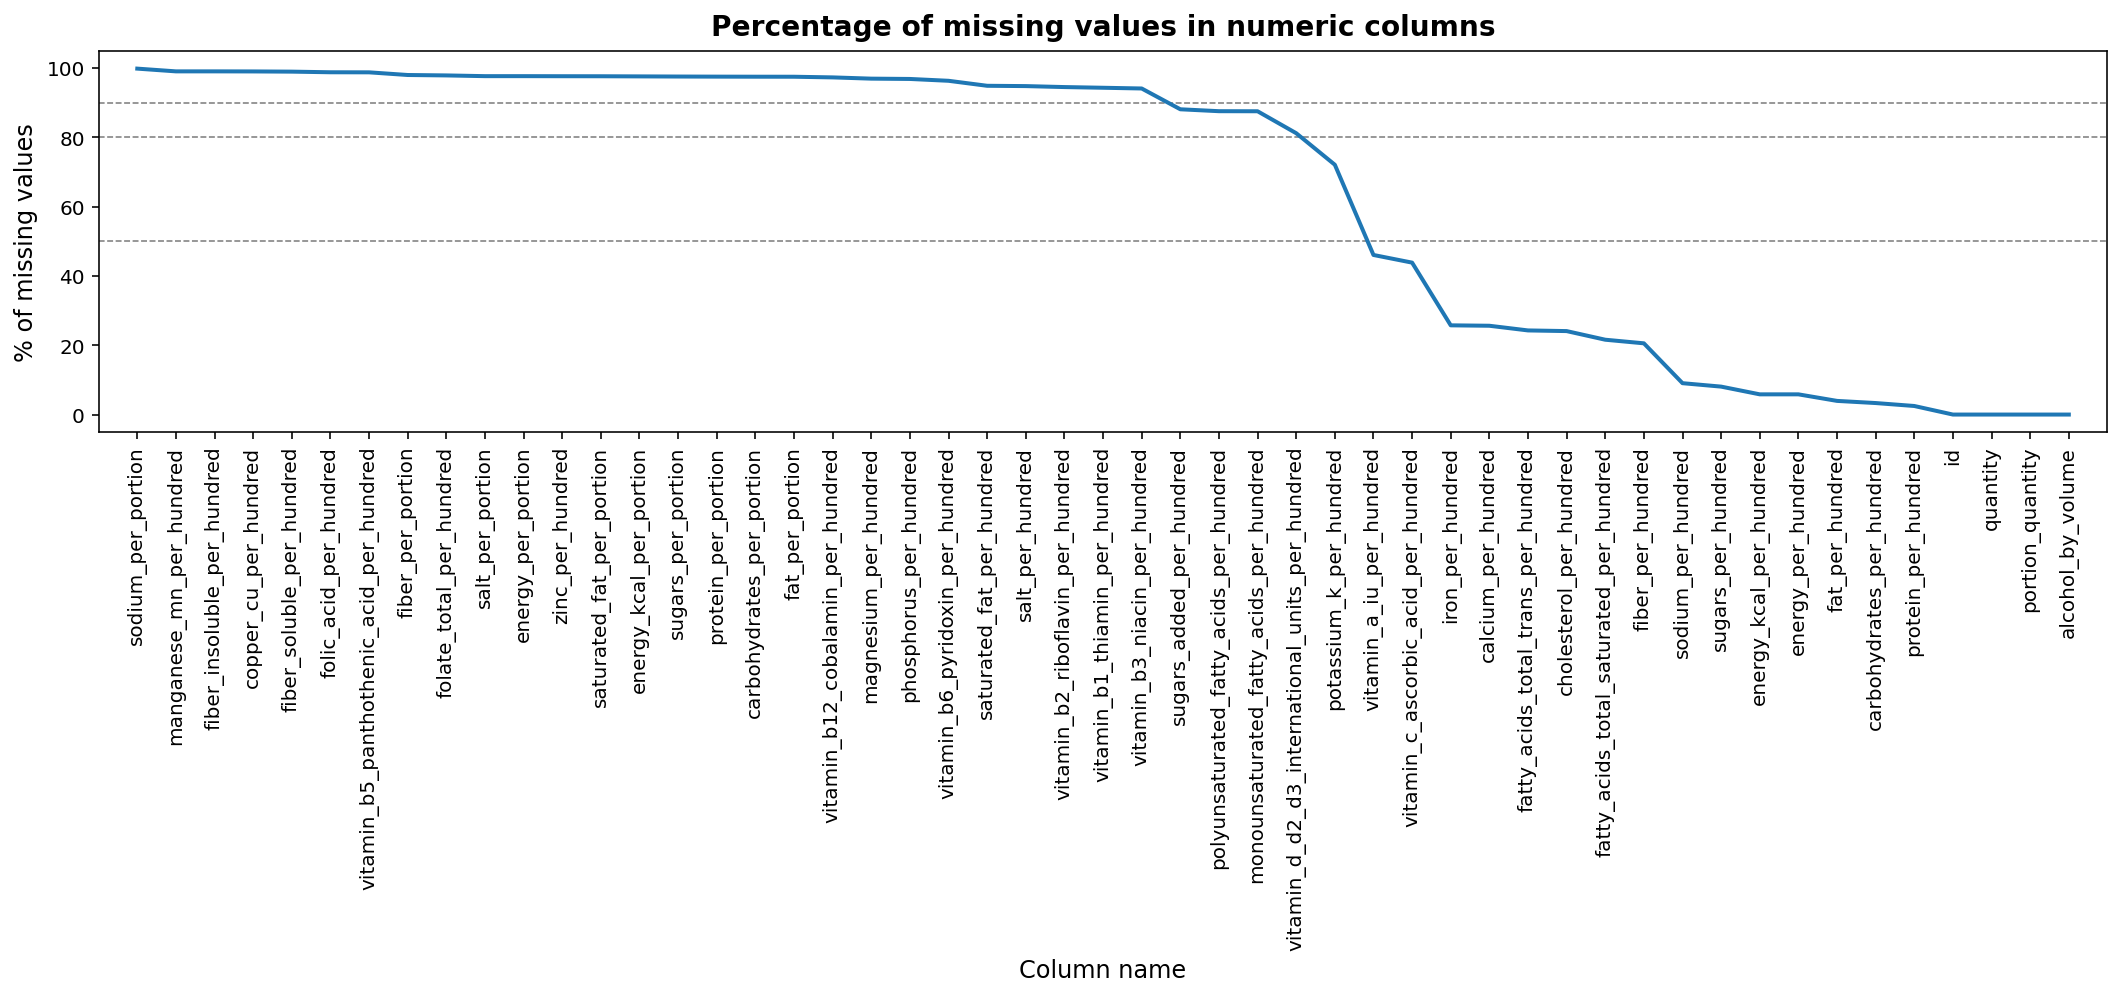

In [38]:
# Plot percentage of missing data in numerical data

plot_missing_values(df,num_cols,'numeric')

In [39]:
# Update lists of categorical and numeric columns

cat_cols = df.select_dtypes(exclude=np.number).columns
num_cols = df.select_dtypes(include=np.number).columns

print('Found {} numeric columns.'.format(len(num_cols)))
print('Found {} categorical columns.'.format(len(cat_cols)))

Found 51 numeric columns.
Found 46 categorical columns.


There are still many missing values in numeric columns. There may be a few reasons for this:
* if the amount of nutrients isn't in `*_per_hundred` columns, then it may provided in the corresponding `*_per_portion` columns.
* a specific nutrient isn't present in the given product.

In [40]:
# Create lists of *_per_hundred, and *_per_portion columns

cols_per_hundred = [c for c in df.columns if 'per_hundred' in c]
cols_per_portion = [c for c in df.columns if 'per_portion' in c]

# Show difference between `num_cols` and `*_per_hundred`, and `*_per_portion` columns

list(set(num_cols) - set(cols_per_hundred + cols_per_portion))

['quantity', 'alcohol_by_volume', 'id', 'portion_quantity']

Let's explore the first scenario: *if the amount of nutrients isn't in `*_per_hundred`, then it is provided in the `*_per_portion` columns.*

First, we need to create a dictionary that maps the `*_per_hundred` column name to the `*per_portion` name.

In [41]:
# Map `*_per_hundred` columns to `*per_portion` columns

hundred_to_portion_col_names = dict((c, '_'.join(c.split('_')[:-1])+'_portion') for c in cols_per_hundred 
                                    if '_'.join(c.split('_')[:-1])+'_portion' in num_cols)

# Show `*_per_hundred` to `*per_portion` mapping
hundred_to_portion_col_names

{'carbohydrates_per_hundred': 'carbohydrates_per_portion',
 'energy_kcal_per_hundred': 'energy_kcal_per_portion',
 'energy_per_hundred': 'energy_per_portion',
 'fat_per_hundred': 'fat_per_portion',
 'fiber_per_hundred': 'fiber_per_portion',
 'protein_per_hundred': 'protein_per_portion',
 'salt_per_hundred': 'salt_per_portion',
 'saturated_fat_per_hundred': 'saturated_fat_per_portion',
 'sodium_per_hundred': 'sodium_per_portion',
 'sugars_per_hundred': 'sugars_per_portion'}

As we see, 10 `per_hundred` columns have a `per_portion` "sibling". Below, we check how many missing values from the `per_hundred` columns are available in the `per_portion_cols`.

In [42]:
df_info_missing = df[cols_per_hundred].isnull().sum().rename('NaNs').to_frame()

vals_in_per_portion = []

for c in cols_per_hundred:
    if c in hundred_to_portion_col_names.keys():
        pair_col = hundred_to_portion_col_names[c]
        vals_in_per_portion.append(len(df.loc[(df[c].isnull()) & (df[pair_col].notnull())]))
    else:
        vals_in_per_portion.append(np.nan)
        
df_info_missing['vals_in_per_portion_cols'] = vals_in_per_portion

df_info_missing.sort_values(by='vals_in_per_portion_cols',ascending=False).head(10)

,NaNs,vals_in_per_portion_cols
fat_per_hundred,14033,271.0
protein_per_hundred,8799,261.0
carbohydrates_per_hundred,11819,253.0
sugars_per_hundred,28685,243.0
saturated_fat_per_hundred,337682,238.0
energy_kcal_per_hundred,20743,235.0
fiber_per_hundred,73145,166.0
energy_per_hundred,20761,164.0
salt_per_hundred,337374,149.0
sodium_per_hundred,32234,120.0


It's not much, but anyways, let's replace the missing values in the `*per_hundred` columns using the values in the `per_portion` columns.

In [43]:
for c in hundred_to_portion_col_names.keys():
    pair_col = hundred_to_portion_col_names[c]
    df[c] = pd.Series(np.where(df[c].isnull(),df[pair_col]*(100/df['portion_quantity']), df[c]))
    
    df.loc[(df[c] == np.inf),c] = np.nan

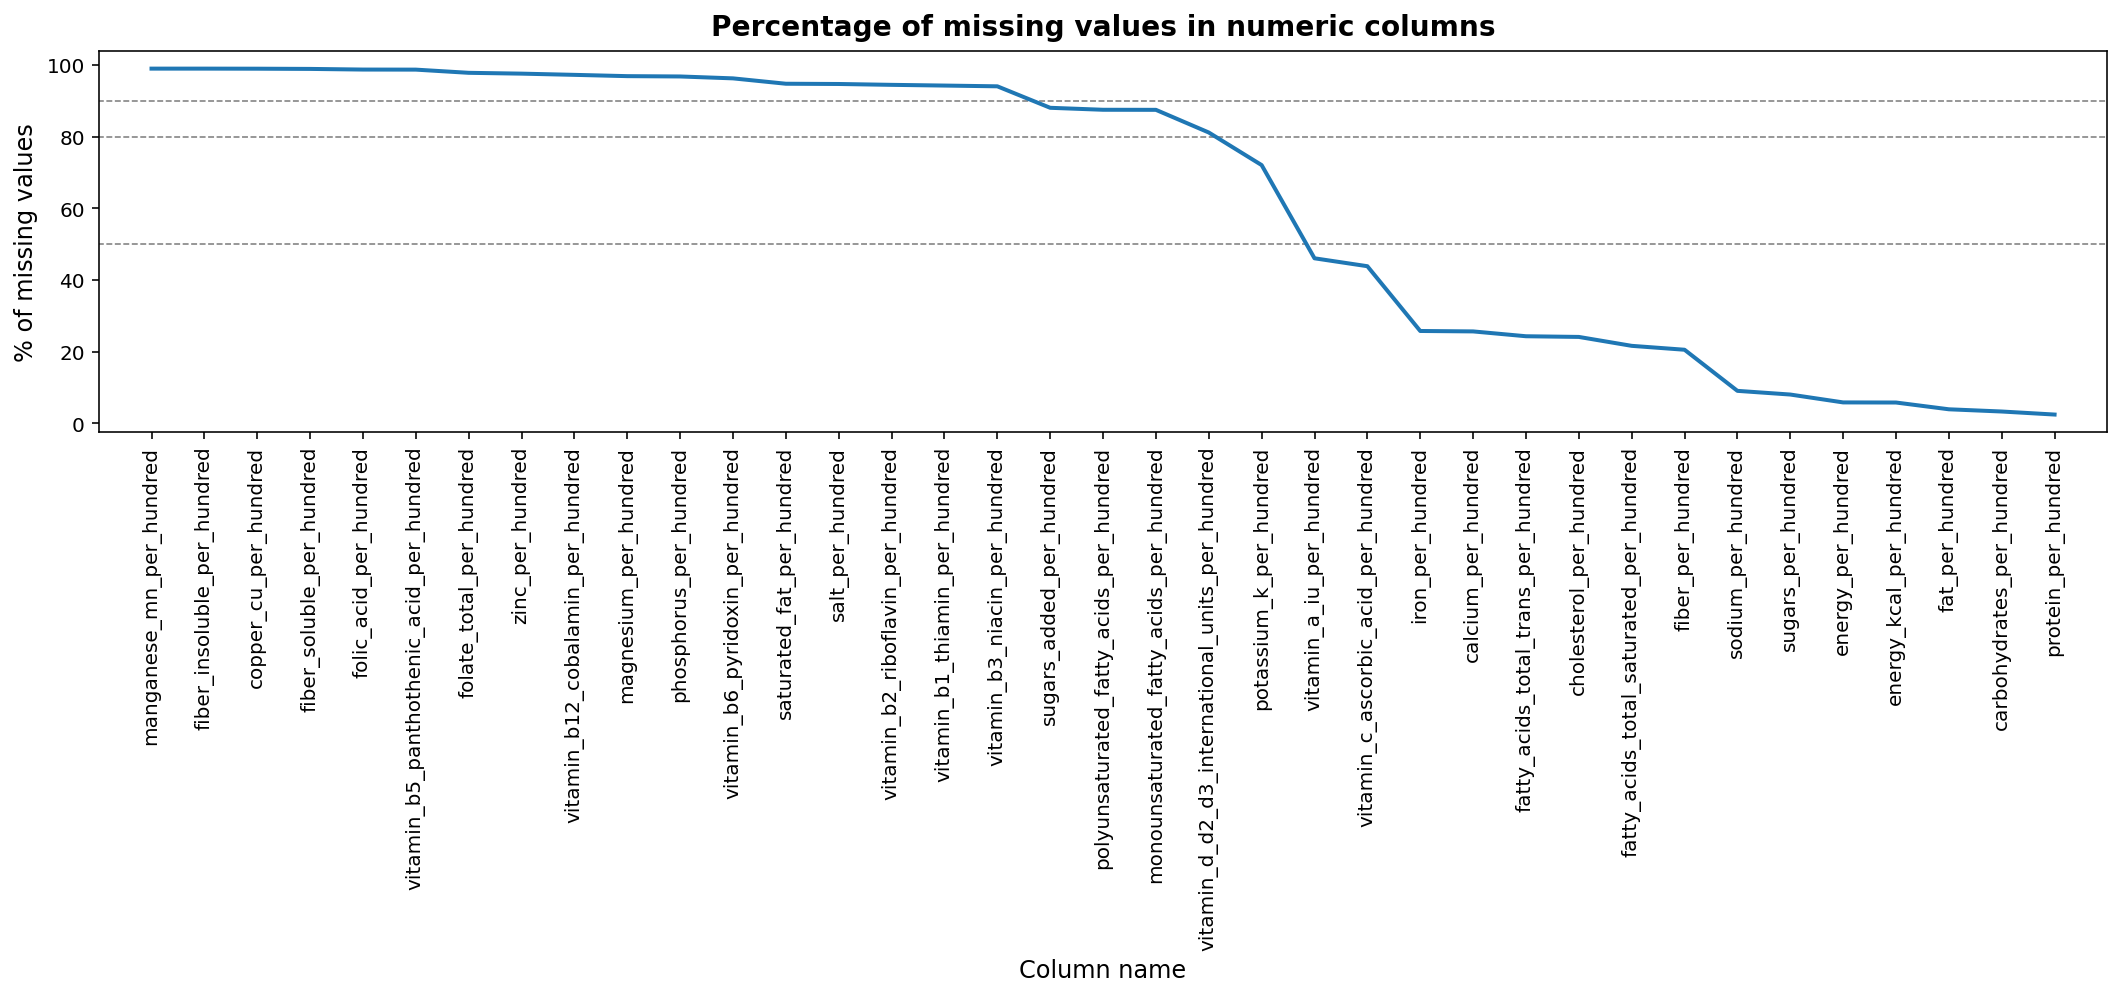

In [44]:
plot_missing_values(df,cols_per_hundred,'numeric')

#### The energy_per_hundred column

Let's focus on one example: the `energy_per_hundred` column. It seems that sometimes when the `energy_per_hundred` is missing, it is available in the `energy_kcal_per_hundred` column.

In [45]:
interesting_cols = ['product_name','energy_per_hundred','energy_kcal_per_hundred', 'barcode']
df.loc[(df['energy_per_hundred'].isnull()) & (df['energy_kcal_per_hundred'].notnull()),interesting_cols]

,product_name,energy_per_hundred,energy_kcal_per_hundred,barcode
25,gingo : ginger + lemon,NaN,0.045833,0628055080015
232,pastry,NaN,408.000000,7616700165159
617,bolets séché,NaN,310.000000,7610845355666
619,site wine vinegar,NaN,3.000000,0043646230721
727,pignons,NaN,613.333333,7613331697875
...,...,...,...,...
355398,siren - chocolate chip cookie protein bites,NaN,437.500000,0862768000407
355405,molson - canadian lager,NaN,40.281690,0068213031112
355459,granini - orange,NaN,43.000000,7613287061171
355601,tao kae noi - crispy seaweed,NaN,110.000000,8857107231774


Yes, this happens 169 times in the data. Below, we will replace missing values in `energy_per_hundred` using the value in `energy_kcal_per_hundred` (if available).

The conversion factors for joules and calories are: 
* 1 kJ = 0.239 kcal
* 1 kcal = 4.184 kJ

[Source](https://www.fao.org/3/y5022e/y5022e04.htm)

In [46]:
# Replace missing values in `energy_per_hundred` by value in `energy_kcal_per_hundred` (if available).

print('Before: number of missing values {}'.format(df['energy_per_hundred'].isnull().sum()))
df['energy_per_hundred'] = pd.Series(np.where(df['energy_per_hundred'].isnull(),0.239 * df['energy_kcal_per_hundred'],df['energy_per_hundred']))
print('After: number of missing values {}'.format((df['energy_per_hundred'].isnull().sum())))

Before: number of missing values 20610
After: number of missing values 20441


Let's do one more check by plotting the `energy_per_hundred` column against the `energy_kcal_per_hundred` column. In principle, it should be: 

$\frac{kJ}{kCal}$ = 0.239

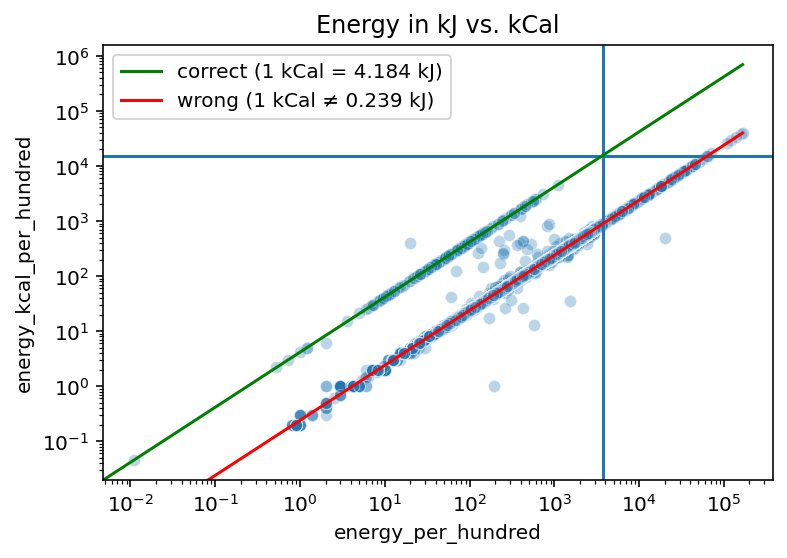

In [47]:
# energy in kJ vs. kCal

sns.scatterplot(data = df, x = 'energy_per_hundred', y = 'energy_kcal_per_hundred',alpha=0.3);
plt.title('Energy in kJ vs. kCal')
plt.xscale('log')
plt.yscale('log')
plt.axvline(x=3700, ymin=0, ymax=np.log(1e6))
plt.axhline(y=4.184*3700, xmin=0, xmax=np.log(1e6));

x_vals = np.linspace(df['energy_per_hundred'].min(),df['energy_per_hundred'].max(),10)

plt.plot(x_vals,4.184*x_vals, color='green',label='correct (1 kCal = 4.184 kJ)'); # Correct formula: kCal = 4.184 kJ
plt.plot(x_vals,0.239*x_vals, color='red',label='wrong (1 kCal ≠ 0.239 kJ)');   # Wrong formula: kCal ≠ 0.239 kJ
plt.legend();

As we can see, there are mistakes in the data; in some products, a wrong formula was used to convert between kJ and kCal.

I'm not sure if I can do anything about this, since I don't know whether it's the energy values in kJ or in kCal that are correct.

In [48]:
# Update lists of columns

cat_cols = df.select_dtypes(exclude=np.number).columns
num_cols = df.select_dtypes(include=np.number).columns

print('Found {} numeric columns.'.format(len(num_cols)))
print('Found {} categorical columns.'.format(len(cat_cols)))

Found 51 numeric columns.
Found 46 categorical columns.


In [49]:
# Sort the columns for their non-null values (ascending) and add the column of the percent of missing values

missing_values_table(df,num_cols)

,NaNs,non_NaNs,NaNs_perc,dtype
columns,,,,
sodium_per_portion,355298,720,99.8,float64
fiber_insoluble_per_hundred,352509,3509,99.0,float64
manganese_mn_per_hundred,352484,3534,99.0,float64
copper_cu_per_hundred,352407,3611,99.0,float64
fiber_soluble_per_hundred,352191,3827,98.9,float64
folic_acid_per_hundred,351572,4446,98.8,float64
vitamin_b5_panthothenic_acid_per_hundred,351493,4525,98.7,float64
fiber_per_portion,348762,7256,98.0,float64
folate_total_per_hundred,348322,7696,97.8,float64


#### Salt vs. sodium columns

Let's have a closer look at the 'salt_per_hundred' and 'sodium_per_hundred' columns, as they are related. In fact, to convert sodium to salt, we need to multiply the amount by 2.5. 

In [50]:
missing_values_table(df,['salt_per_hundred','sodium_per_hundred'])

,NaNs,non_NaNs,NaNs_perc,dtype
columns,,,,
salt_per_hundred,337236,18782,94.7,float64
sodium_per_hundred,32116,323902,9.0,float64


The `salt_per_hundred` column is much emptier than the `sodium_per_hundred` column. So we could use the values in tthe `sodium_per_hundred` column to replace missing values in the `salt_per_hundred` column.

In [51]:
interesting_cols = ['product_name','salt_per_hundred','sodium_per_hundred', 'barcode']
df.loc[(df['salt_per_hundred'].isnull()) & (df['sodium_per_hundred'].notnull()),interesting_cols]

,product_name,salt_per_hundred,sodium_per_hundred,barcode
25,gingo : ginger + lemon,NaN,0.004167,0628055080015
37,orangina: with pulp,NaN,0.000000,7610525300795
129,cristalp,NaN,19.900000,7610534012108
142,evian - sport,NaN,650.000000,3068320014067
172,naturaplan - dark chocolate with almond chips ...,NaN,0.070000,7610848493136
...,...,...,...,...
355772,goat cheese creamy,NaN,0.333333,0096619090907
355773,"brown rice, lightly salted rice cakes",NaN,0.149254,0646670316029
355775,garlic spread - fresh raw dairy -gluten free,NaN,0.444444,0094922648754
355926,"knutwiler, das mineralwasser der zentralschwei...",NaN,0.500000,7610867000124


Below, we will replace missing values in `salt_per_hundred` using the value in `sodium_per_hundred` (if available).

salt_per_hundred = 2.5 * sodium_per_hundred

In [52]:
df['salt_per_hundred'] = pd.Series(np.where(df['salt_per_hundred'].isnull(),2.5*df['sodium_per_hundred'],df['salt_per_hundred']))

In [53]:
# Check again the percentage of missing values in "salt" columns

missing_values_table(df,['salt_per_hundred','sodium_per_hundred'])

,NaNs,non_NaNs,NaNs_perc,dtype
columns,,,,
sodium_per_hundred,32116,323902,9.0,float64
salt_per_hundred,13930,342088,3.9,float64


Let's do one more check by plotting the `sodium_per_hundred` column against the `salt_per_hundred` column. In principle, the ratio of the two columns should be ~2.5  

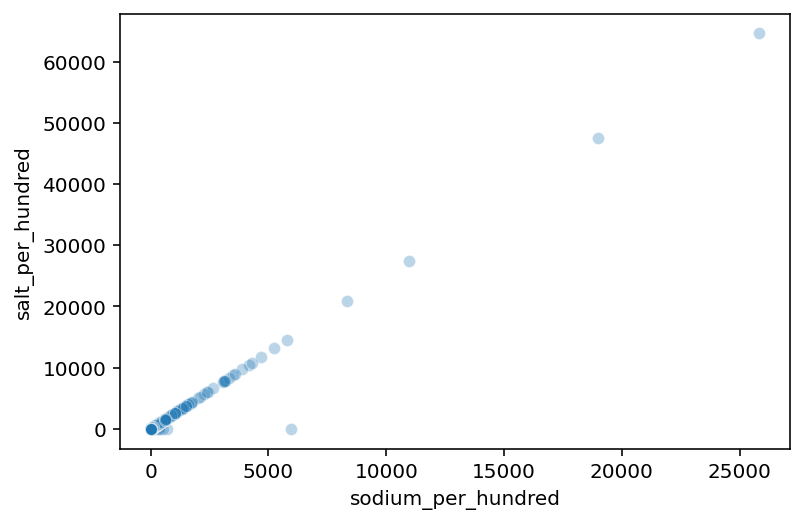

In [54]:
# Sodium vs. salt

sns.scatterplot(data = df, x = 'sodium_per_hundred', y = 'salt_per_hundred',alpha=0.3);

It seems that in a few cases, the values in the 'sodium_per_hundred' column are higher than the values 'salt_per_hundred', which is not the expected behaviour. Let's look closer into these samples.

In [55]:
interesting_cols = ['product_name','salt_per_hundred','sodium_per_hundred', 'barcode']
df.loc[df['sodium_per_hundred'] > df['salt_per_hundred'],interesting_cols].sort_values(by='sodium_per_hundred', ascending=False)

,product_name,salt_per_hundred,sodium_per_hundred,barcode
355113,"powerbar - 5 electrolytes (mango, passionfruit)",15.00,5952.00,42289630
14238,henniez,0.00,700.00,7610235060569
17465,"sponser - pro recovery (high-tech formula, van...",1.30,520.00,7611174181506
6429,riberalves portion of frozen desalted cod msc,1.02,400.00,5601809350669
18641,milupa - safari biscuits,0.90,350.00,7611471000913
...,...,...,...,...
3170,coop qualité & prix chocato drink,0.01,0.05,7610807014907
10790,"m budget red beet, cute",0.00,0.03,7610200425232
12313,alnatura mouliné de bœuf,0.01,0.03,4104420138506
2025,coop naturaplan fraises confiture,0.00,0.03,7610849096992


So, in these cases, we will correct the values in the `sodium_per_hundred` column, using the values in the `salt_per_hundred` column divided by 2.5.

In [56]:
df['sodium_per_hundred'] = pd.Series(np.where(df['sodium_per_hundred'] > df['salt_per_hundred'], df['salt_per_hundred']/2.5,df['sodium_per_hundred']))

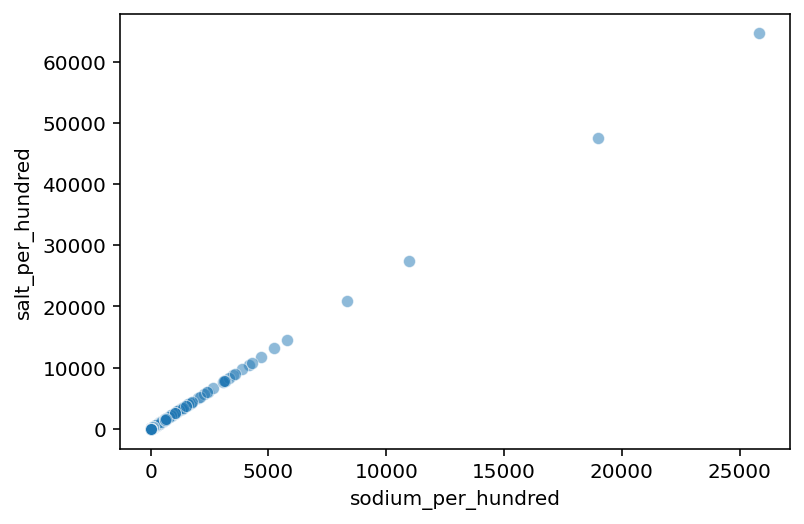

In [57]:
# Sodium vs. salt

sns.scatterplot(data = df, x = 'sodium_per_hundred', y = 'salt_per_hundred',alpha=0.5);

Ok, this now looks fine.

### Task B.4 : Top values in categorical data

> Let’s continue exploring the categorical variables in more detail. What is the number of unique values in categorical variables? What are the topmost frequent values in categorical variables?

In [58]:
# Define nbr of top values to show in df_EDA
N = 10  

# Create empty lists
nunique_list  = []
top_values    = []
frequencies   = []
nnotnull_list = []

for c in cat_cols:
    nunique_list.append(df[c].nunique())
    nnotnull_list.append(df[c].notnull().sum())
    top_values.append(list(pd.value_counts(df[c]).index[0:N]))
    frequencies.append(pd.value_counts(df[c]).values[0:N])

df_EDA = pd.DataFrame({'Feature':cat_cols,
                       'N_unique':nunique_list,
                       'N_notnull':nnotnull_list,
                       'Top_values':top_values,
                       'Frequency':frequencies})

#temporarily display all the rows
with pd.option_context('display.max_rows', len(df_EDA)):
    display(df_EDA.sort_values('N_unique',ascending=True))

,Feature,N_unique,N_notnull,Top_values,Frequency
22,monounsaturated_fatty_acids_unit,1,356018,[g],[356018]
23,phosphorus_unit,1,356018,[mg],[356018]
24,polyunsaturated_fatty_acids_unit,1,356018,[g],[356018]
26,potassium_k_unit,1,356018,[mg],[356018]
28,protein_unit,1,356018,[g],[356018]
29,salt_unit,1,356018,[g],[356018]
30,saturated_fat_unit,1,356018,[g],[356018]
31,sodium_unit,1,356018,[g],[356018]
32,sugars_added_unit,1,356018,[g],[356018]
33,sugars_unit,1,356018,[g],[356018]


Below, we plot the number of unique values in categorical data using barplots.

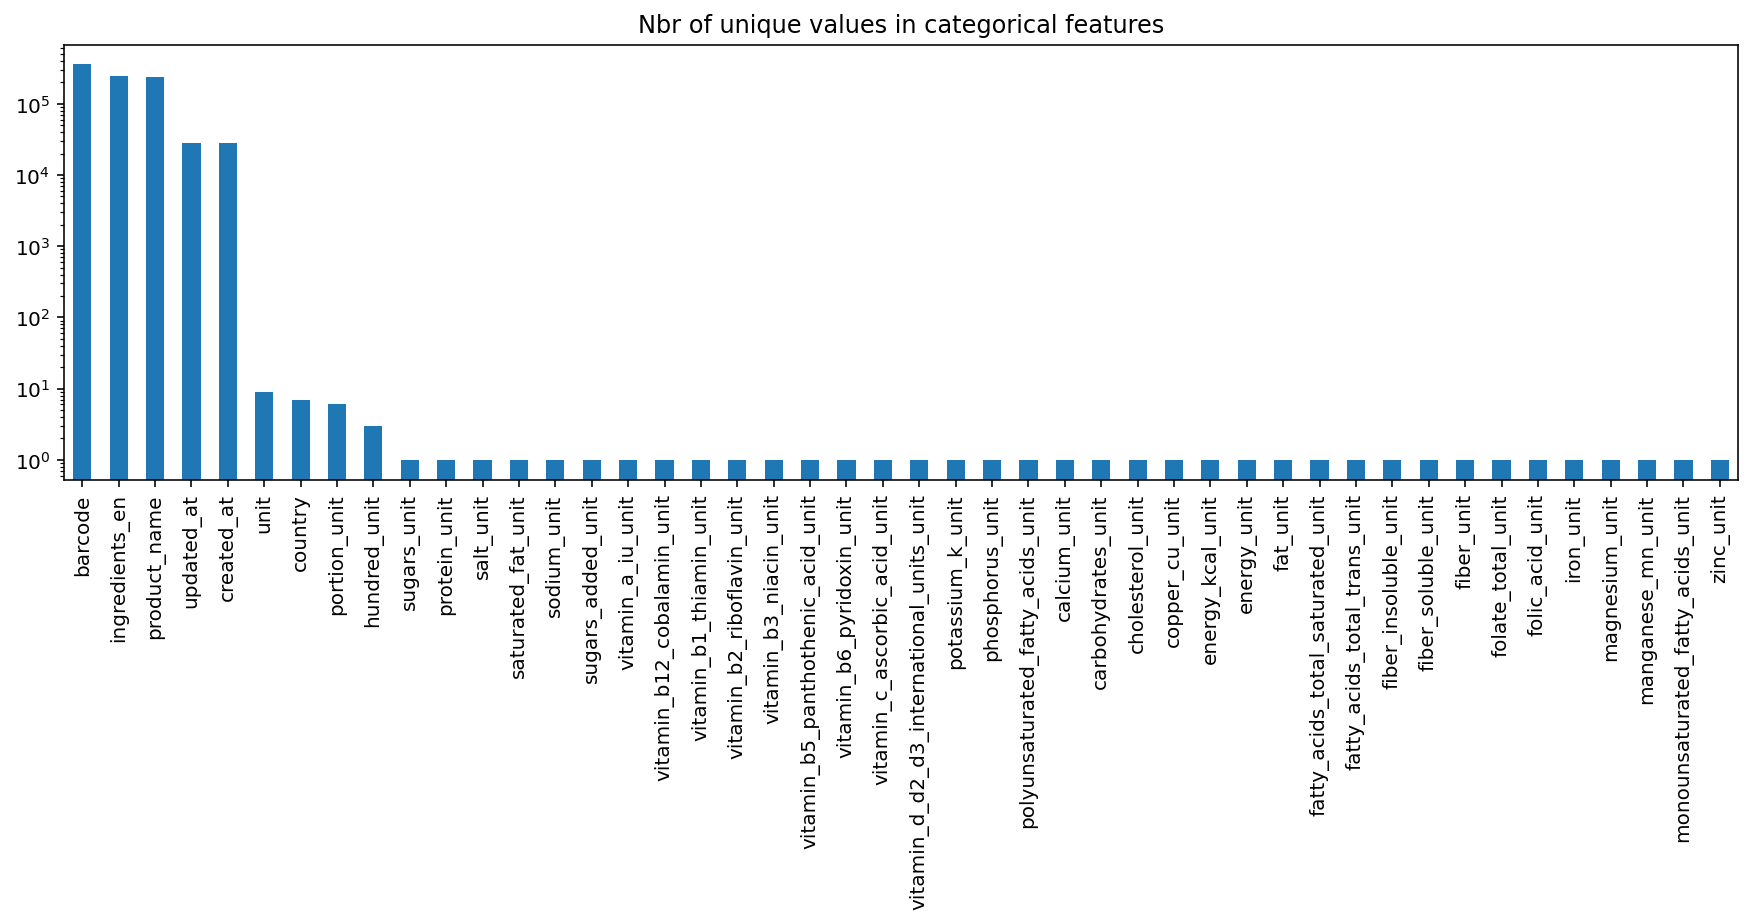

In [59]:
df[cat_cols].nunique().sort_values(ascending=False).plot.bar(logy=True, 
                                                             figsize=(15, 4), 
                                                             title="Nbr of unique values in categorical features");

Below we plot the sample distribution across unique labels in the following columns: unit, and country

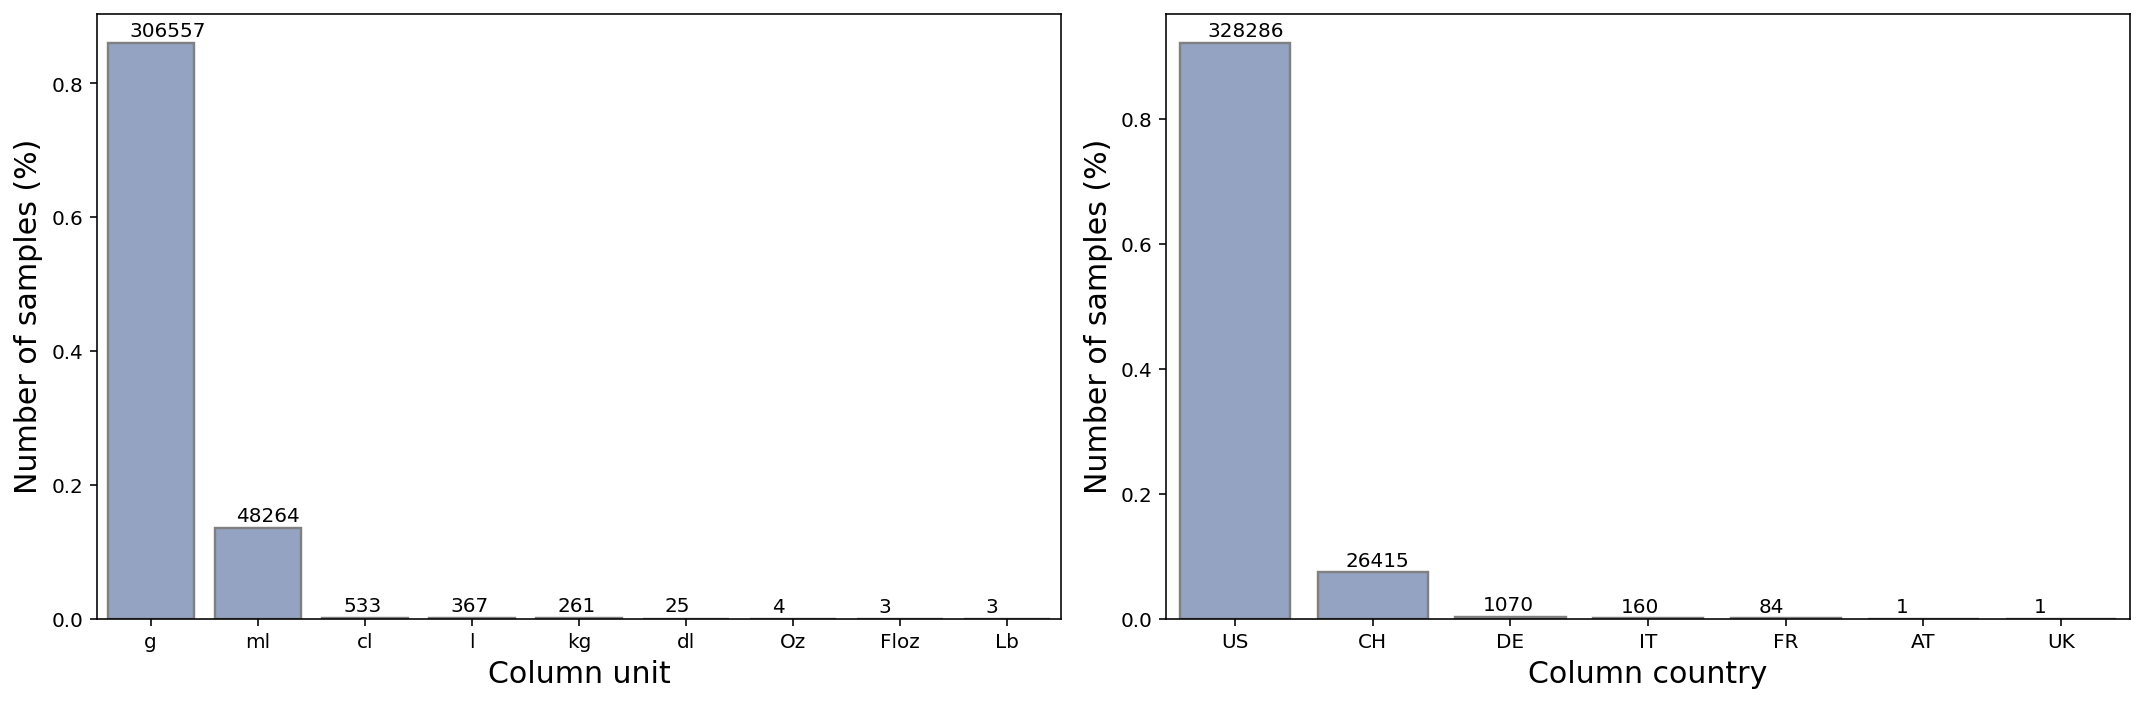

In [60]:
fig,axes = plt.subplots(1,2,figsize=(15,5))

label_specs   = {"fontsize": 15}
title_specs   = {"fontsize": 15, "fontweight": "bold", "y": 1.03}

for c,ax in zip(['unit', 'country'],axes.ravel()):
    w = df[c].value_counts(normalize=True)

    sns.barplot(x = w.index, y = w.values, edgecolor='grey', lw=1.2, color = COLOR_1, ax = ax);
    ax.set_xlabel('Column {}'.format(c), **label_specs)
    ax.set_ylabel('Number of samples (%)', **label_specs);
    #ax.set_title("Distribution of samples in column {}".format(c),**title_specs)

    for i, c in enumerate(w.index):
        ax.text(x = i-0.2, y = w.loc[c]+0.01, s=int(len(df)*w.loc[c]))
plt.tight_layout()

### Task B.5: Distribution of numeric variables

> What about the numerical variables? Can you provide descriptive statistics (e.g., min/max/mean) and informative plots (e.g., histograms) of the numerical variables? You should obtain these plots as subplots.

In [61]:
with pd.option_context('display.max_rows', len(df[num_cols])):
    display(df[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
alcohol_by_volume,356018.0,0.023564,0.719012,0.0,0.000,0.000,0.0000,57.900000
calcium_per_hundred,264818.0,116.627281,2558.081719,0.0,0.000,36.000,102.0000,684000.000000
carbohydrates_per_hundred,344440.0,33.319309,29.214171,0.0,6.670,23.360,60.0000,127.142857
carbohydrates_per_portion,9013.0,18.679383,17.242707,0.0,7.000,15.500,25.0000,148.000000
cholesterol_per_hundred,270277.0,58.982449,1934.736852,0.0,0.000,0.000,25.0000,250000.000000
copper_cu_per_hundred,3611.0,5.468045,274.468684,0.0,0.210,0.480,1.0700,16483.520000
energy_kcal_per_hundred,335496.0,272.159874,258.963691,0.0,89.000,267.000,400.0000,39600.000000
energy_kcal_per_portion,8701.0,155.588113,131.171331,0.0,78.000,126.000,191.0000,1508.000000
energy_per_hundred,335577.0,1137.548832,1082.173383,0.0,372.380,1117.130,1673.6000,165686.400000
energy_per_portion,8448.0,643.867398,536.608942,0.0,324.000,529.000,794.0000,5212.000000


Below I create a new list to hold the columns with the `per_hundred` suffix in their names.

In [62]:
cols_hundred = [c for c in num_cols if 'hundred' in c and 'kcal' not in c]
print('Found {} columns'.format(len(cols_hundred)))
print(cols_hundred)

Found 36 columns
['calcium_per_hundred', 'carbohydrates_per_hundred', 'cholesterol_per_hundred', 'copper_cu_per_hundred', 'energy_per_hundred', 'fat_per_hundred', 'fatty_acids_total_saturated_per_hundred', 'fatty_acids_total_trans_per_hundred', 'fiber_insoluble_per_hundred', 'fiber_per_hundred', 'fiber_soluble_per_hundred', 'folate_total_per_hundred', 'folic_acid_per_hundred', 'iron_per_hundred', 'magnesium_per_hundred', 'manganese_mn_per_hundred', 'monounsaturated_fatty_acids_per_hundred', 'phosphorus_per_hundred', 'polyunsaturated_fatty_acids_per_hundred', 'potassium_k_per_hundred', 'protein_per_hundred', 'salt_per_hundred', 'saturated_fat_per_hundred', 'sodium_per_hundred', 'sugars_added_per_hundred', 'sugars_per_hundred', 'vitamin_a_iu_per_hundred', 'vitamin_b12_cobalamin_per_hundred', 'vitamin_b1_thiamin_per_hundred', 'vitamin_b2_riboflavin_per_hundred', 'vitamin_b3_niacin_per_hundred', 'vitamin_b5_panthothenic_acid_per_hundred', 'vitamin_b6_pyridoxin_per_hundred', 'vitamin_c_asco

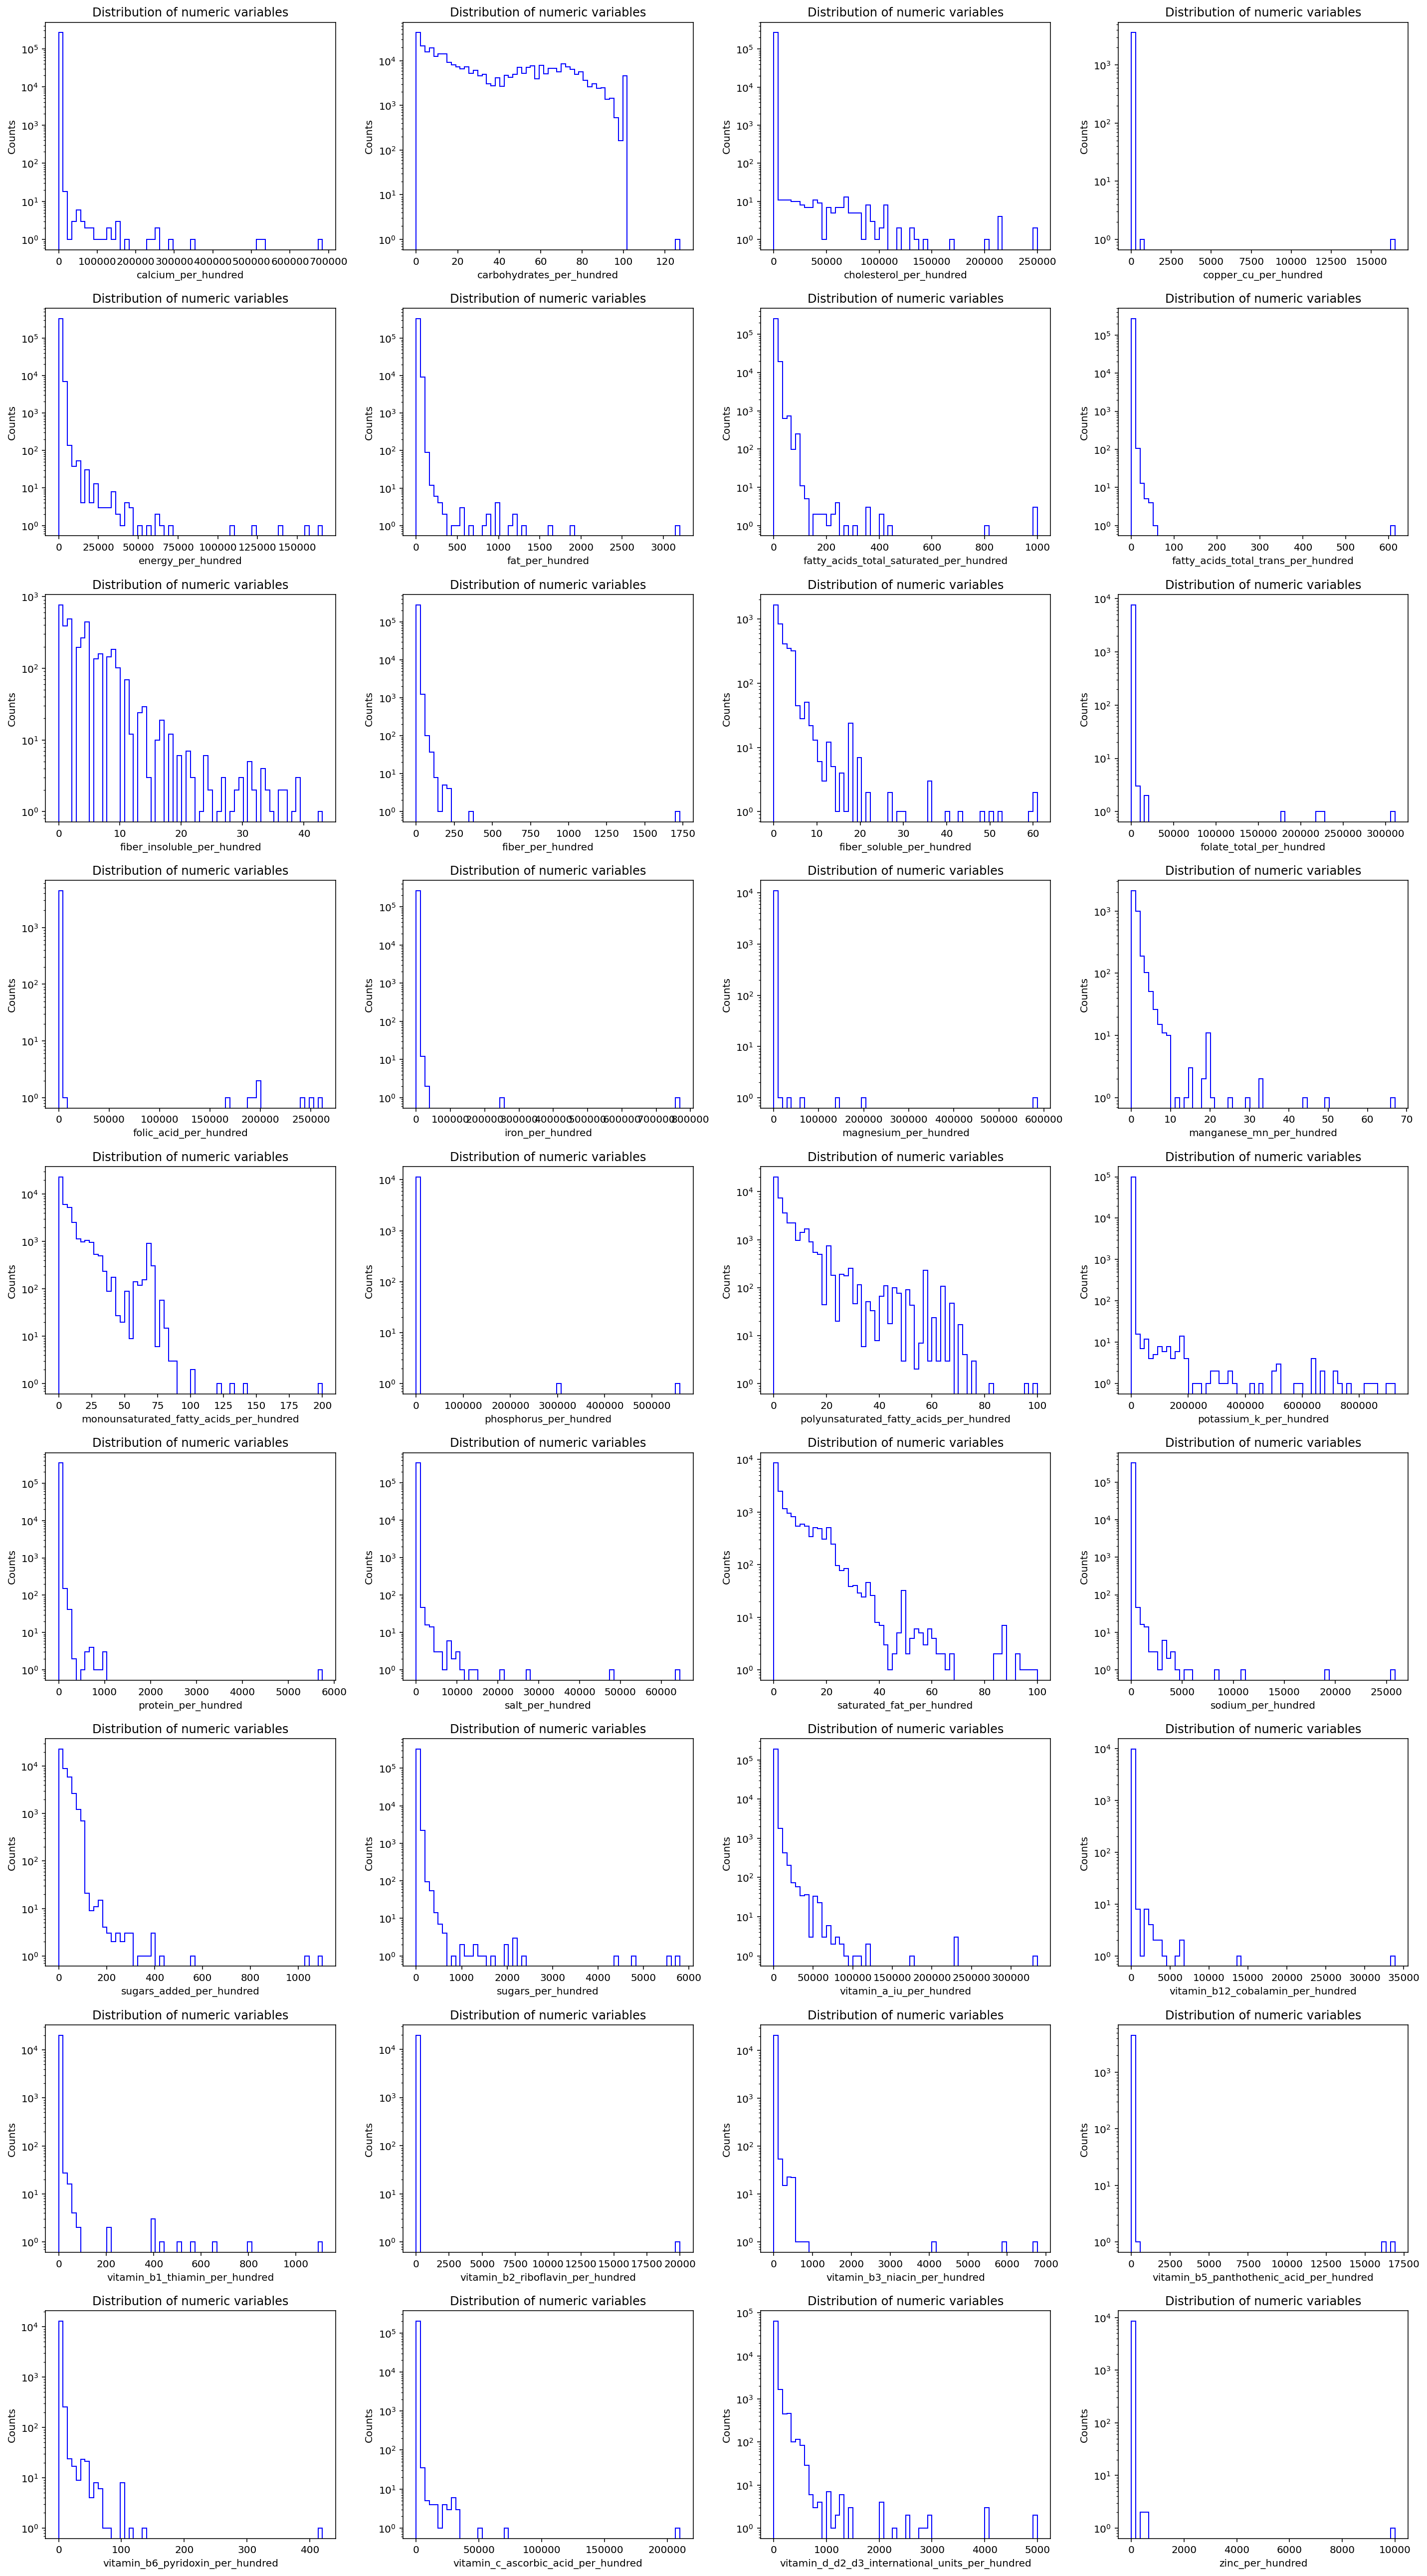

In [63]:
# Distribution of numeric variables

fig,axes = plt.subplots(9,4,figsize=(20,9*4))

for c, ax in zip(cols_hundred, axes.ravel()):
    
    ax.hist(df.loc[df[c].notnull(),c],bins=60, color='blue', histtype=u'step');
    ax.set_xlabel(c)
    ax.set_ylabel('Counts')
    ax.set_yscale('log')
    ax.set_title('Distribution of numeric variables')
    
plt.tight_layout()

### Task B.6 : Address errors in numeric columns

> After completing the previous task, you should have noticed a few abnormal values (errors) in the numerical columns. Your next goal is to address the mistakes in the columns with the `per_hundred` suffix in their names (e.g. `protein_per_hundred`, `fat_per_hundred`, etc.). Below are some hints.
>    * Create a new list to hold the columns with the `per_hundred` suffix in their names.
>    * What is the range of acceptable values in each column? This may depend on the unit of each column. You can find the unit of each column in the associated `unit` column. For example, the `protein_per_hundred` column unit is found in the `protein_unit` column, etc.
>    * The unit of the `protein_per_hundred` column is `g`, which means that the values in this column should range between 0 and 100.
>    * If a column's unit is `mg`, then the values should range between 0 and $10^{5}$ (=$100$/$10^{-3}$). 
>    * If a column's unit is in International units (IU), you can use the "Mass equivalents of 1 IU" indicated on this [Wikipedia page](https://en.wikipedia.org/wiki/International_unit) to define an upper threshold value for this column.
>    * Once you address errors in the `per_hundred` columns, plot them again using histograms.

I guess now, we need to check for incorrect values. 😊

From the Open Food repo Documentation: 

> * "hundred_unit: The unit used for the "per hundred" product nutrients (g or ml)."
> * The sum of protein, fat, carbohydrates, salt and fibre can not exceed 100 gr

The unit varies depending on the nutrient.

In [64]:
# Map `*_per_hundred` columns to their unit

nutrient_to_units_d = dict((c, df['_'.join(c.split('_')[:-2])+'_unit'][0]) for c in cols_per_hundred)

pd.DataFrame({'column_name':nutrient_to_units_d.keys(),'units':nutrient_to_units_d.values()}).set_index('column_name')

,units
column_name,
calcium_per_hundred,mg
carbohydrates_per_hundred,g
cholesterol_per_hundred,mg
copper_cu_per_hundred,mg
energy_kcal_per_hundred,kCal
energy_per_hundred,kJ
fat_per_hundred,g
fatty_acids_total_saturated_per_hundred,g
fatty_acids_total_trans_per_hundred,g


In [65]:
set(nutrient_to_units_d.values())

{'IU', 'g', 'kCal', 'kJ', 'mg', 'µg'}

This also means that the upper boundary also depends on the unit.

- If the unit is g, then the upper theshold in the `_per_hundred` column should be: 100
- If the unit is mg, then the upper theshold in the `_per_hundred` column should be: $100/10^{-3}=10^5$
- If the unit is µg, then the upper theshold in the `_per_hundred` column should be: $100/10^{-6}=10^8$
- If the unit is IU, then the upper theshold in the `_per_hundred` column is more [complicated](https://en.wikipedia.org/wiki/International_unit).
    * 1 IU of Vitamin A = 0.3 μg -> $100/(0.3 10^{-6})= 10^9/3$
    * 1 IU  of vitamin D = 0.025 μg: $100/(0.025 10^{-6})= 4.10^9$

In [66]:
# Create dict to hold upper thresholds bases on unit
unit_to_upper_thesh = {}

unit_to_upper_thesh['g'] = 100
unit_to_upper_thesh['mg'] = 10**5
unit_to_upper_thesh['µg'] = 10**8
unit_to_upper_thesh['IU_vit_a'] = 100/(0.3*1.e-6)
unit_to_upper_thesh['IU_vit_d'] = 100/(0.025*1.e-6)
unit_to_upper_thesh['kJ'] = 3700
unit_to_upper_thesh

{'g': 100,
 'mg': 100000,
 'µg': 100000000,
 'IU_vit_a': 333333333.3333334,
 'IU_vit_d': 4000000000.0,
 'kJ': 3700}

In [67]:
# Replot distribution of numeric colums showing plausible range of values this time

num_errors = []
error_perc = []
col_units  = []
col_thresh = []
N_notnull  = []
max_val    = []

for c in cols_hundred:
    
    unit = nutrient_to_units_d[c]
    
    if unit == 'IU':
        if c == 'vitamin_a_iu_per_hundred':
            thresh = unit_to_upper_thesh['IU_vit_a']
        else:
            thresh = unit_to_upper_thesh['IU_vit_d']
    else:       
        thresh = unit_to_upper_thesh[unit]
    
    number_errors = df[c].dropna().apply(lambda x: True if x>thresh else False).astype(int).sum()
    num_errors.append(number_errors)
    
    error_perc.append(100*number_errors/len(df[c].dropna()))
    
    N_notnull.append(len(df[c].dropna()))
    max_val.append(df[c].max())
    
    # Retrieve unit
    col_units.append(unit)
    col_thresh.append(thresh)
     
df_errors = pd.DataFrame({'Feature':cols_hundred,
                          '# vals_above_thresh':num_errors,
                          'non_NaNs':N_notnull,
                          'vals_above_thresh (%)':error_perc,
                          'units':col_units,
                          'max_value':max_val,
                         'upper thresh':col_thresh})

df_errors['vals_above_thresh (%)'] = df_errors['vals_above_thresh (%)'].apply(lambda x:np.round(x,1))
df_errors.set_index('Feature',inplace=True)

with pd.option_context('display.max_rows', len(cols_hundred)):
    display(df_errors.sort_values(by='vals_above_thresh (%)',ascending=False))

,# vals_above_thresh,non_NaNs,vals_above_thresh (%),units,max_value,upper thresh
Feature,,,,,,
energy_per_hundred,833,335577,0.2,kJ,165686.400000,3.700000e+03
sugars_added_per_hundred,96,42478,0.2,g,1100.000000,1.000000e+02
salt_per_hundred,320,342088,0.1,g,64583.325000,1.000000e+02
sodium_per_hundred,190,323902,0.1,g,25833.330000,1.000000e+02
sugars_per_hundred,443,327566,0.1,g,5800.000000,1.000000e+02
potassium_k_per_hundred,81,99444,0.1,mg,925000.000000,1.000000e+05
calcium_per_hundred,18,264818,0.0,mg,684000.000000,1.000000e+05
vitamin_b12_cobalamin_per_hundred,0,9734,0.0,µg,33898.310000,1.000000e+08
saturated_fat_per_hundred,0,18563,0.0,g,100.000000,1.000000e+02


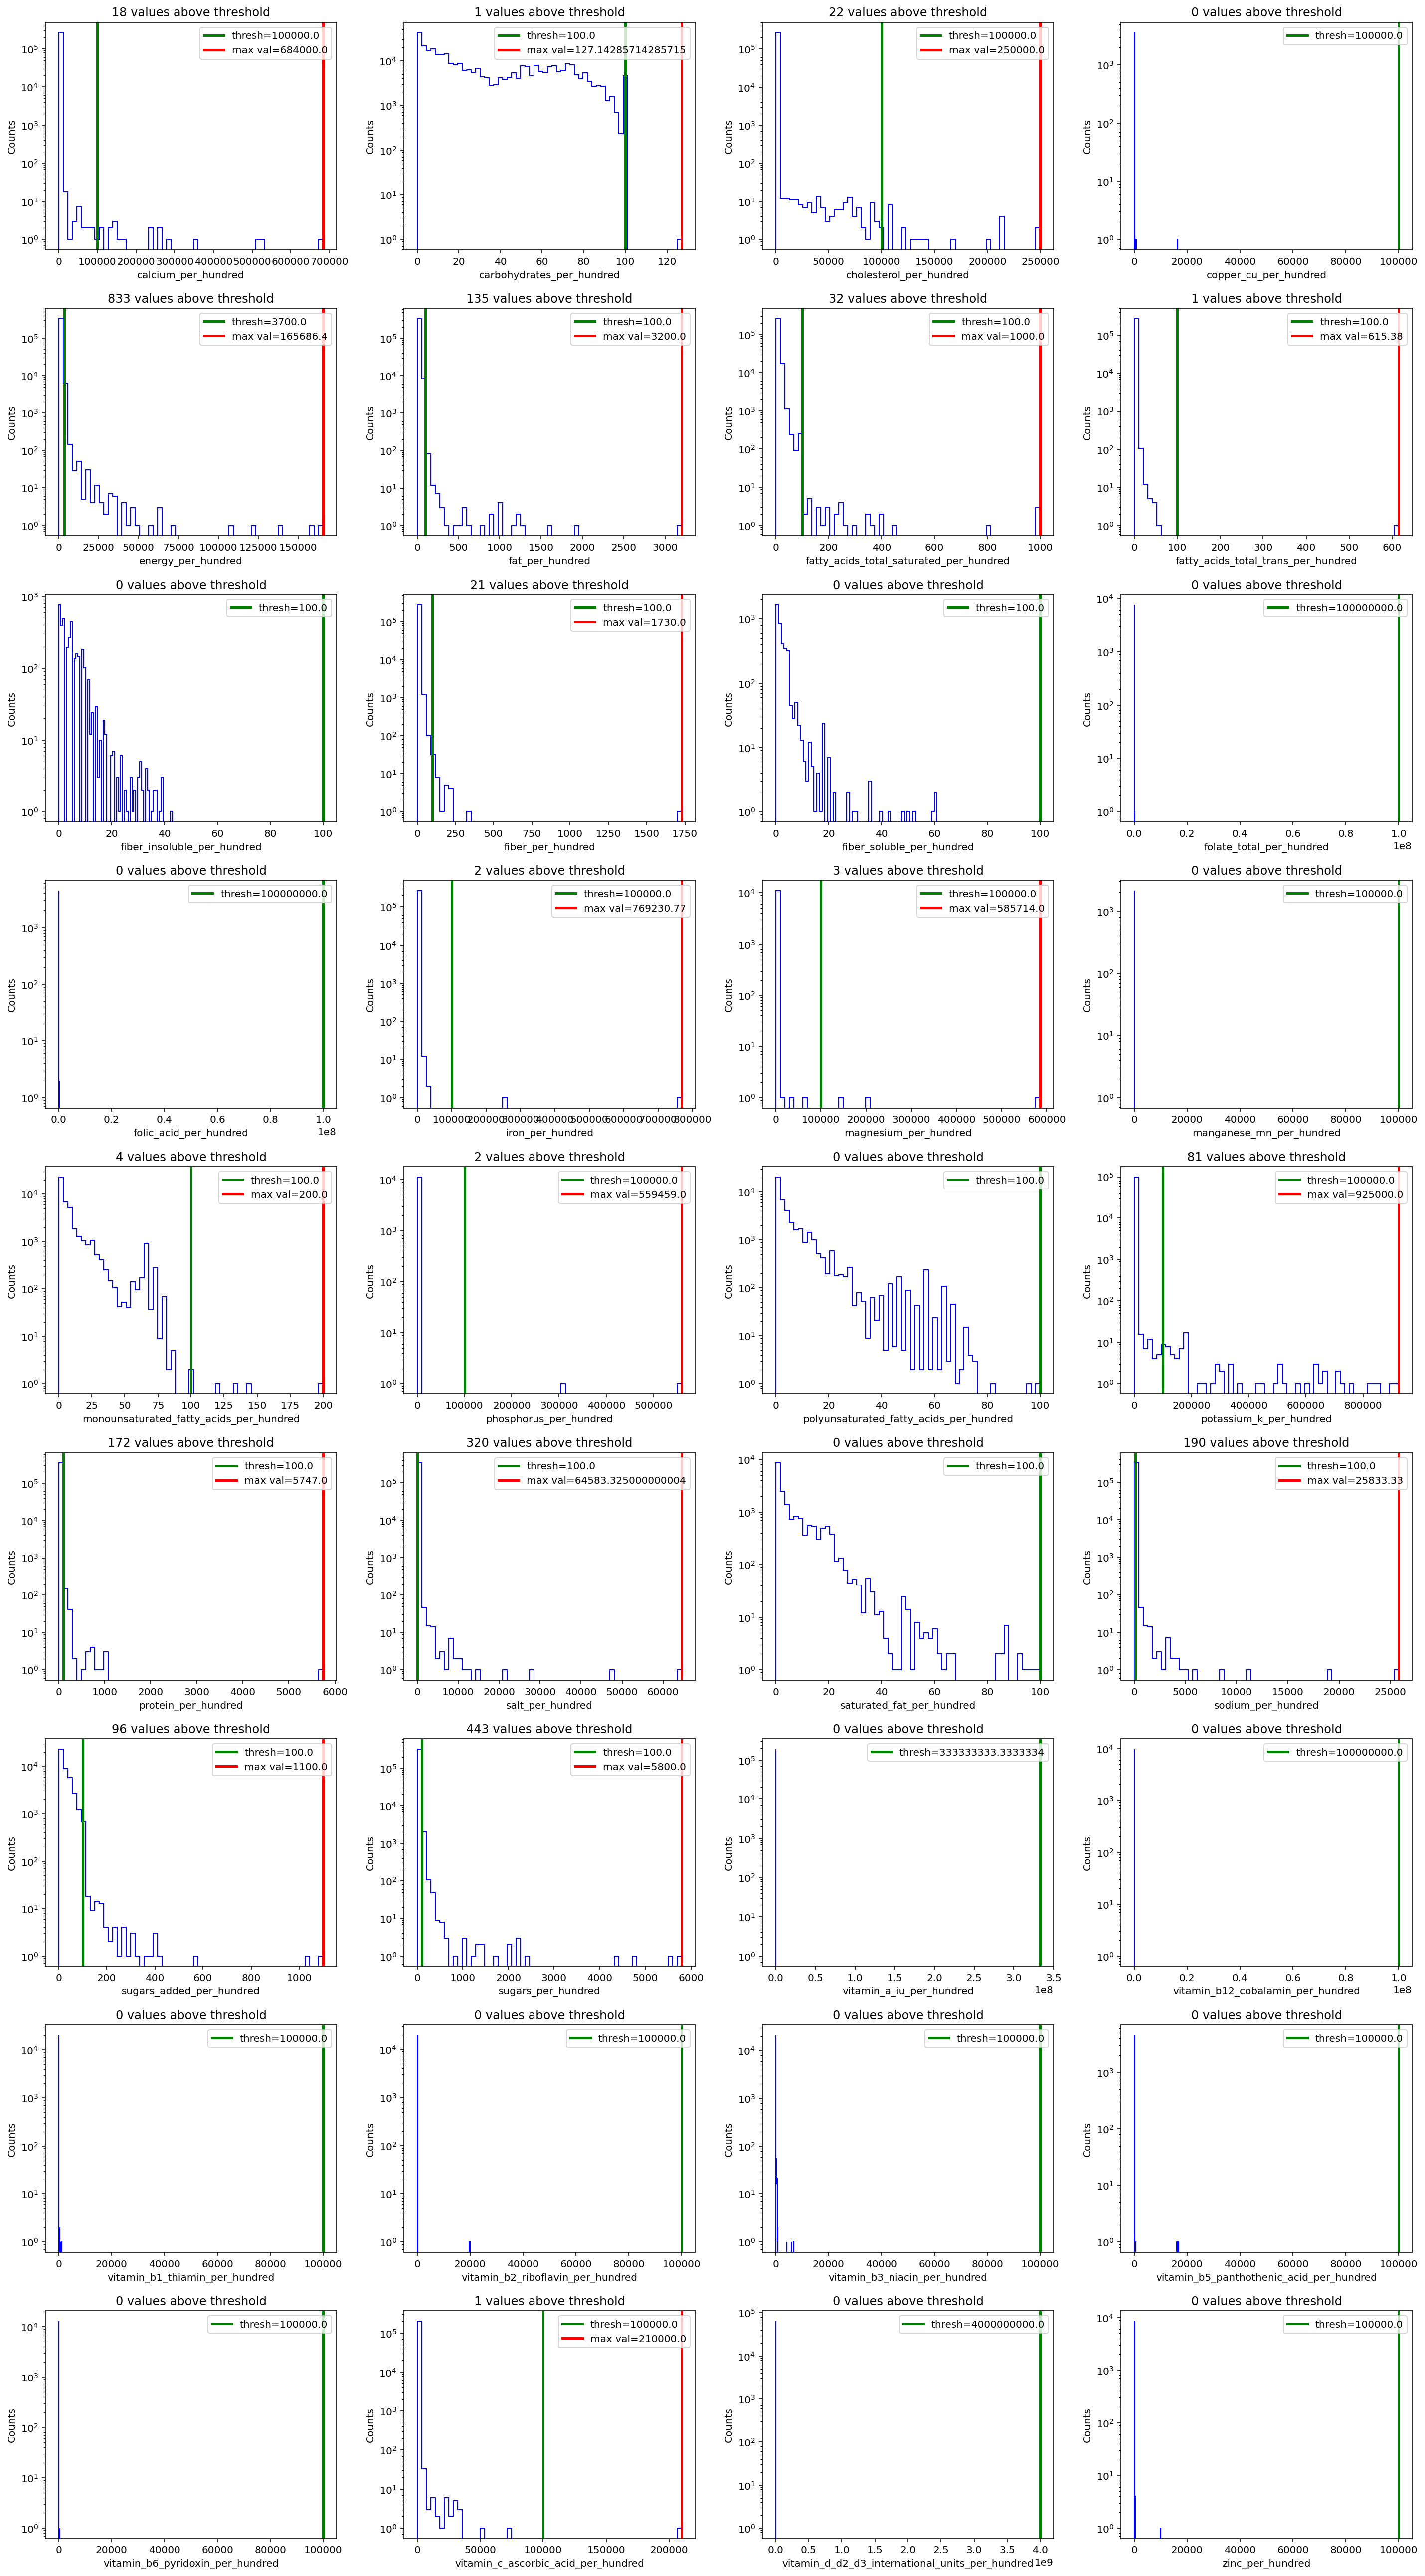

In [68]:
# Replot distribution of numeric colums showing plausible range of values this time

fig,axes = plt.subplots(9,4,figsize=(20,9*4))

bins = np.linspace(0, 100, num=60, endpoint=True)

for c, ax in zip(cols_hundred, axes.ravel()):
    
    max_val = df_errors.loc[c,'max_value']
    thresh  = df_errors.loc[c,'upper thresh']
    vals_above_thresh = df_errors.loc[c,'# vals_above_thresh'] 
    bins = np.linspace(0, max_val, num=60, endpoint=True)
    ax.hist(df.loc[df[c].notnull(),c],bins=bins, color='blue', histtype=u'step', label=None);
    ax.axvline(x=thresh, ymin=0, ymax=len(df), c='green',label=f'thresh={thresh}', lw=2.5)
    if max_val > thresh:
        ax.axvline(x=max_val, ymin=0, ymax=len(df), c='red', label=f'max val={max_val}', lw=2.5)
        
    ax.legend(loc='upper right')
    ax.set_xlabel(c)
    ax.set_ylabel('Counts')
    ax.set_yscale('log')
    ax.set_title(f'{vals_above_thresh} values above threshold')
    
plt.tight_layout()

In [69]:
# Remove incorrect values in numeric variables

df1 = df.copy()
print(df1.shape)

(356018, 97)


In [70]:
# Replace incorrect values by np.nan

for c in cols_hundred:
    
    unit = nutrient_to_units_d[c]
    
    if unit == 'IU':
        if c == 'vitamin_a_iu_per_hundred':
            thresh = unit_to_upper_thesh['IU_vit_a']
        else:
            thresh = unit_to_upper_thesh['IU_vit_d']
    else:       
        thresh = unit_to_upper_thesh[unit]
    
    df1.loc[df1[c]>thresh, c] = np.nan
 

In [71]:
num_errors = []
error_perc = []
col_units  = []
col_thresh = []
N_notnull  = []
max_val    = []

for c in cols_hundred:
    
    unit = nutrient_to_units_d[c]
    
    if unit == 'IU':
        if c == 'vitamin_a_iu_per_hundred':
            thresh = unit_to_upper_thesh['IU_vit_a']
        else:
            thresh = unit_to_upper_thesh['IU_vit_d']
    else:       
        thresh = unit_to_upper_thesh[unit]
    
    number_errors = df1[c].dropna().apply(lambda x: True if x>thresh else False).astype(int).sum()
    num_errors.append(number_errors)
    
    error_perc.append(100*number_errors/len(df1[c].dropna()))
    
    N_notnull.append(len(df1[c].dropna()))
    max_val.append(df1[c].max())
    
    # Retrieve unit
    col_units.append(unit)
    col_thresh.append(thresh)
    
    
df_errors = pd.DataFrame({'Feature':cols_hundred,
                          '# vals_above_thresh':num_errors,
                          'non_NaNs':N_notnull,
                          'vals_above_thresh (%)':error_perc,
                          'units':col_units,
                          'max_value':max_val,
                         'upper thresh':col_thresh})

df_errors['vals_above_thresh (%)'] = df_errors['vals_above_thresh (%)'].apply(lambda x:np.round(x,1))
df_errors.set_index('Feature',inplace=True)

with pd.option_context('display.max_rows', len(cols_hundred)):
    display(df_errors.sort_values(by='vals_above_thresh (%)',ascending=False))

,# vals_above_thresh,non_NaNs,vals_above_thresh (%),units,max_value,upper thresh
Feature,,,,,,
calcium_per_hundred,0,264800,0.0,mg,93750.00,1.000000e+05
carbohydrates_per_hundred,0,344439,0.0,g,100.00,1.000000e+02
protein_per_hundred,0,347295,0.0,g,100.00,1.000000e+02
salt_per_hundred,0,341768,0.0,g,100.00,1.000000e+02
saturated_fat_per_hundred,0,18563,0.0,g,100.00,1.000000e+02
sodium_per_hundred,0,323712,0.0,g,100.00,1.000000e+02
sugars_added_per_hundred,0,42382,0.0,g,100.00,1.000000e+02
sugars_per_hundred,0,327123,0.0,g,100.00,1.000000e+02
vitamin_a_iu_per_hundred,0,192093,0.0,IU,333333.00,3.333333e+08


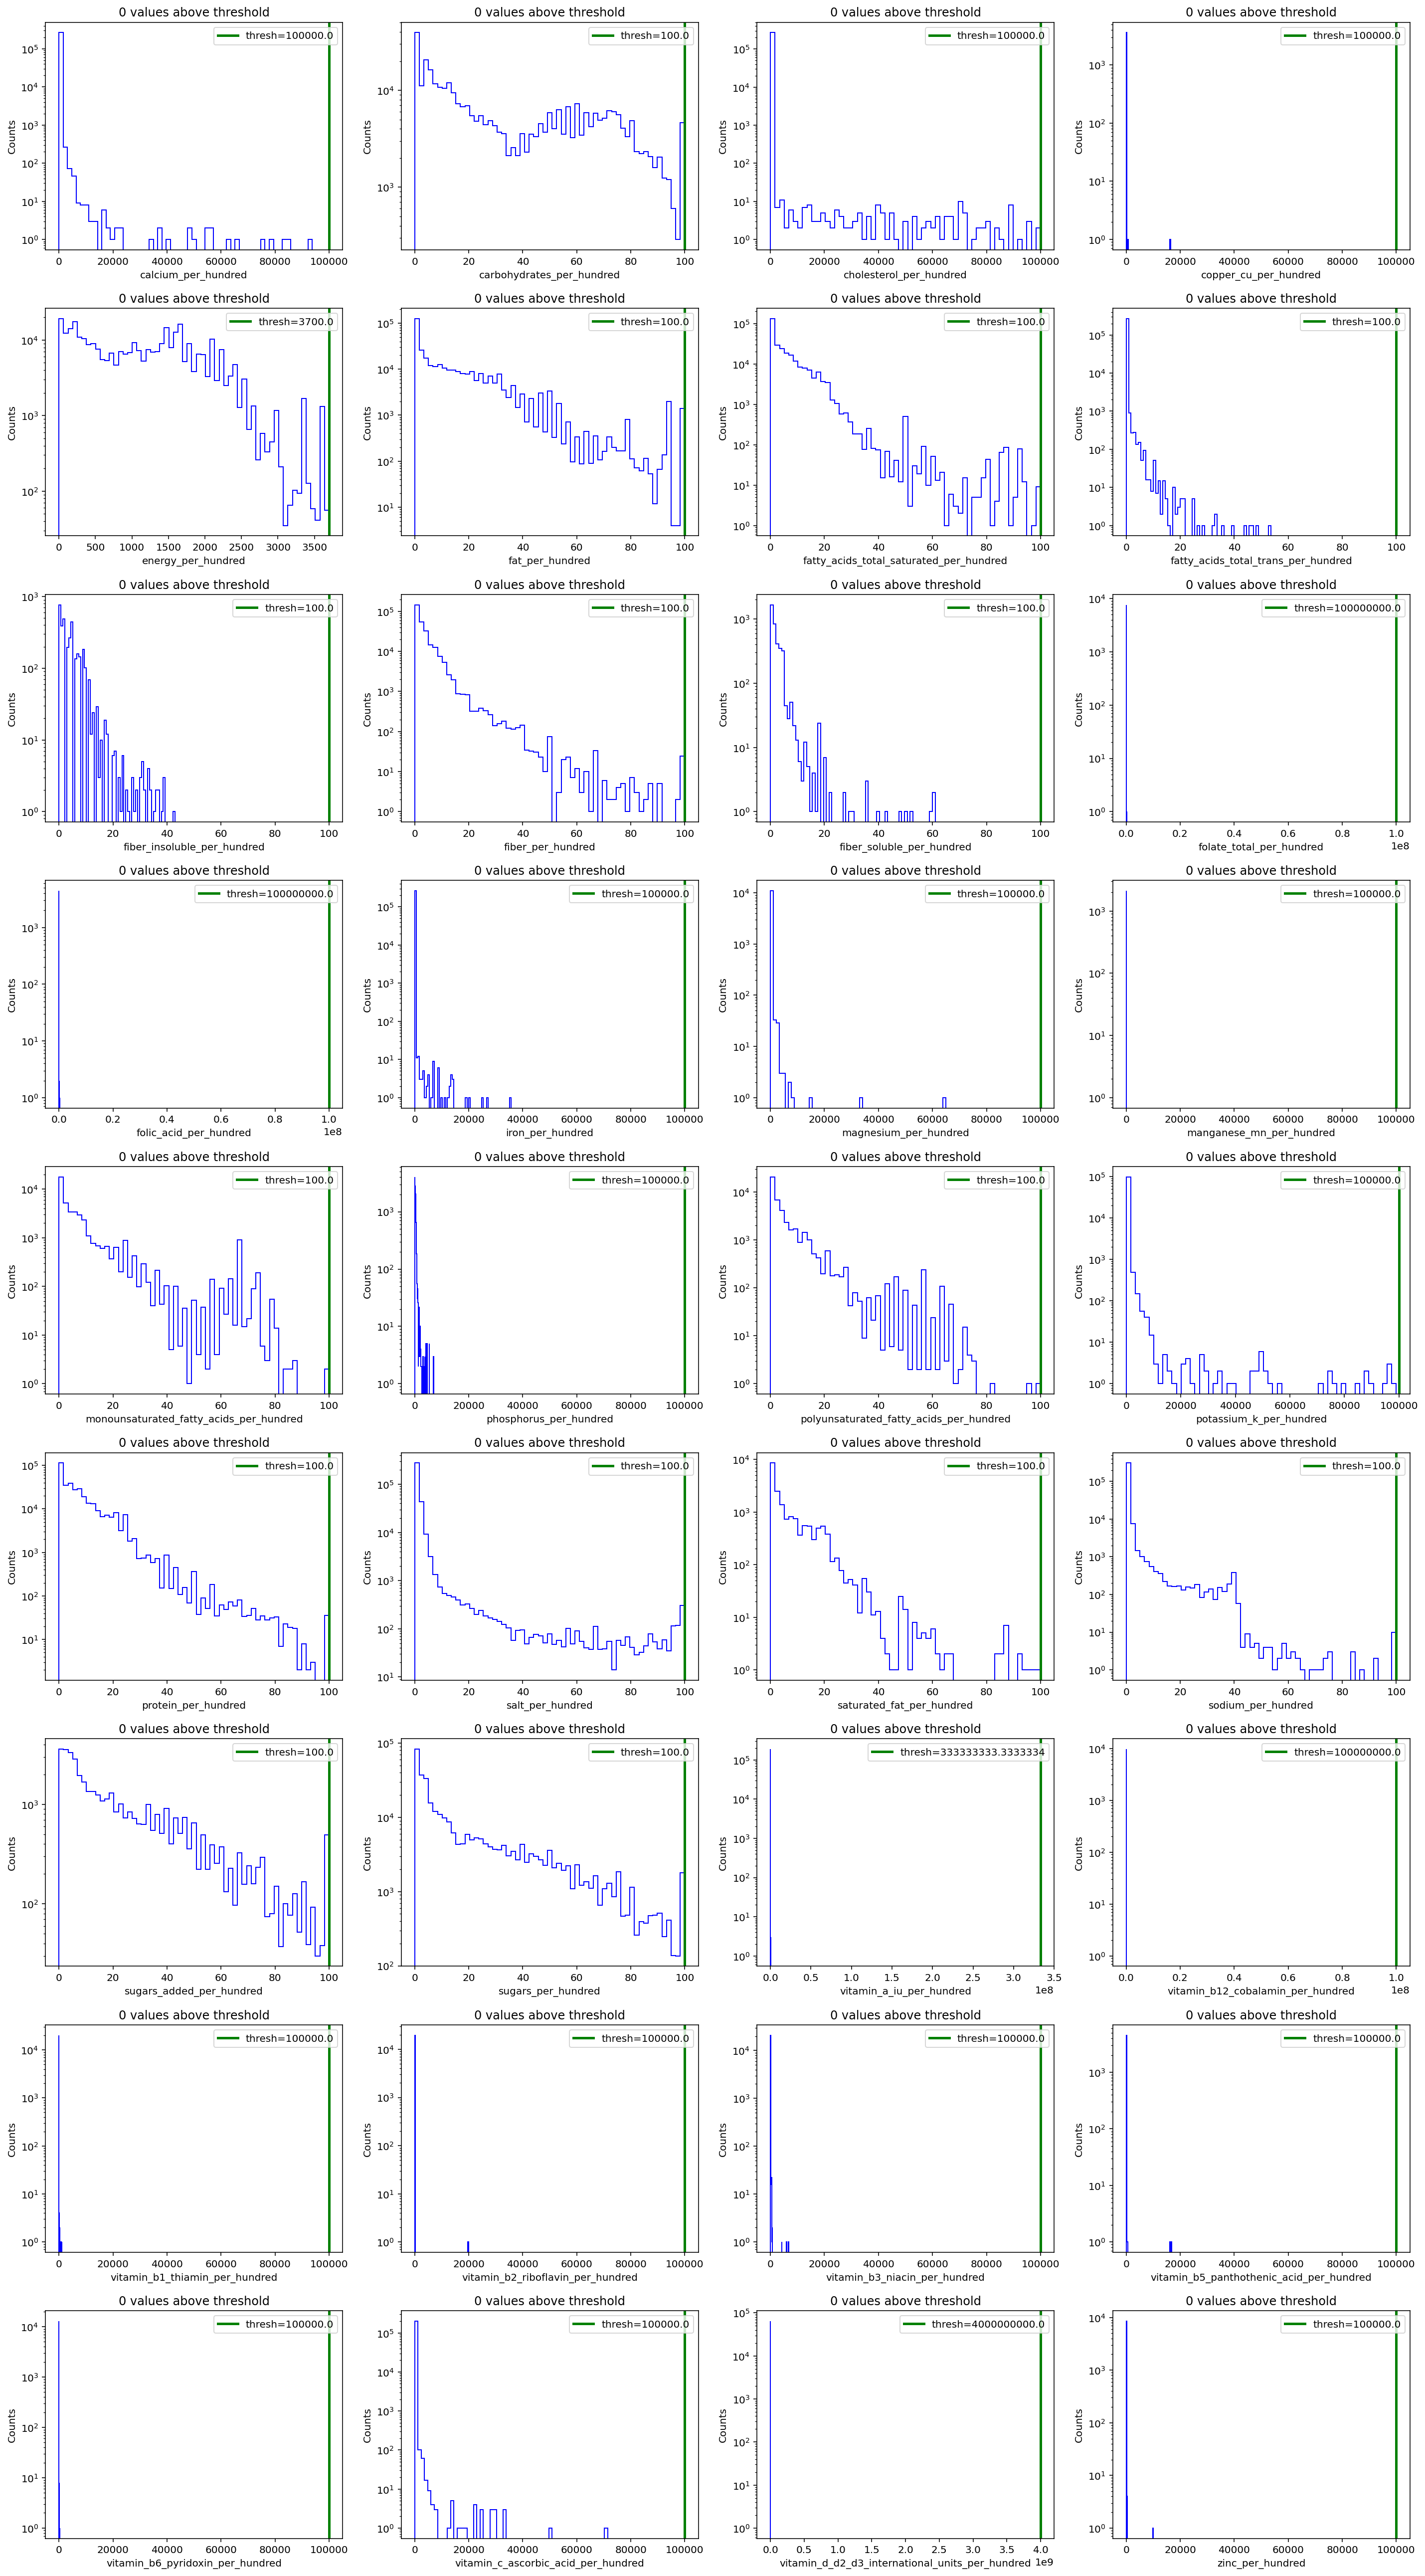

In [72]:
# Once you address errors in the per_hundred columns, plot them again using histograms.

fig,axes = plt.subplots(9,4,figsize=(20,9*4))

bins = np.linspace(0, 100, num=60, endpoint=True)

for c, ax in zip(cols_hundred, axes.ravel()):
    
    max_val = df_errors.loc[c,'max_value']
    thresh  = df_errors.loc[c,'upper thresh']
    vals_above_thresh = df_errors.loc[c,'# vals_above_thresh'] 
    bins = np.linspace(0, max_val, num=60, endpoint=True)
    ax.hist(df.loc[df[c].notnull(),c],bins=bins, color='blue', histtype=u'step', label=None);
    ax.axvline(x=thresh, ymin=0, ymax=len(df), c='green',label=f'thresh={thresh}', lw=2.5)
    if max_val > thresh:
        ax.axvline(x=max_val, ymin=0, ymax=len(df), c='red', label=f'max val={max_val}', lw=2.5)
        
    ax.legend(loc='upper right')
    ax.set_xlabel(c)
    ax.set_ylabel('Counts')
    ax.set_yscale('log')
    ax.set_title(f'{vals_above_thresh} values above threshold')
   
plt.tight_layout()

### Task B.7: More cleaning steps

> Do you spot any other inconsistencies in the data? What about the sum of a product’s protein, fat, carbohydrates, salt, and fiber content?

The sum of protein, fat, carbohydrates, salt and fibre can not exceed 100 gr

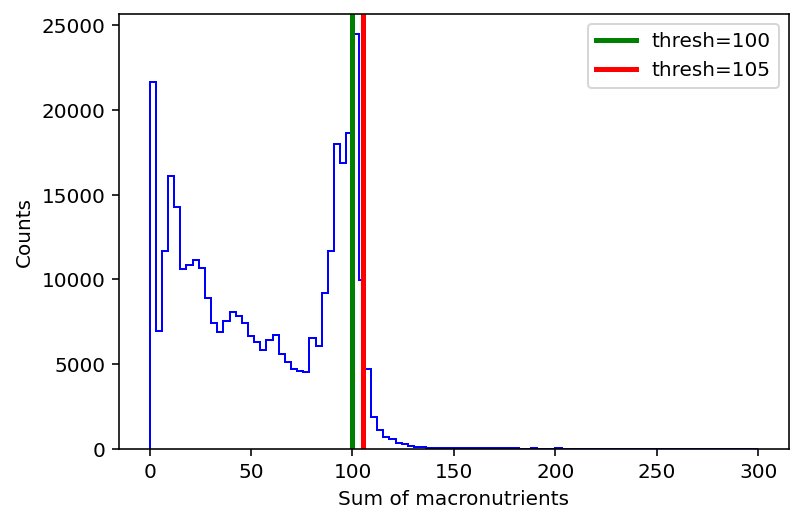

In [73]:
bins = np.linspace(0,df1[['protein_per_hundred','fat_per_hundred', 'carbohydrates_per_hundred', 'salt_per_hundred','fiber_per_hundred']].sum(axis=1).max(),100)
plt.hist(df1[['protein_per_hundred','fat_per_hundred', 'carbohydrates_per_hundred', 'salt_per_hundred','fiber_per_hundred']].sum(axis=1),
        bins = bins, color='blue', histtype=u'step', label=None);
plt.axvline(x=100, ymin=0, ymax=len(df), c='green',label=f'thresh={100}', lw=2.5);
plt.axvline(x=105, ymin=0, ymax=len(df), c='red',label=f'thresh={105}', lw=2.5);
plt.xlabel('Sum of macronutrients');
plt.ylabel('Counts');
plt.legend();

In [74]:
# Let's have a look at a few "problematic" entries

cols = ['protein_per_hundred','fat_per_hundred', 'carbohydrates_per_hundred', 'salt_per_hundred','fiber_per_hundred']
df1.loc[df1[cols].sum(axis=1)>105, ['product_name','barcode']+cols]

,product_name,barcode,protein_per_hundred,fat_per_hundred,carbohydrates_per_hundred,salt_per_hundred,fiber_per_hundred
734,calcium-magnésium,7613269306405,0.000000,0.000000,60.000000,95.000000,0.000000
1217,trident senses berry party flavour,7622210106162,0.400000,2.000000,60.500000,0.000000,60.500000
1223,v6 dental for teeth protection peppermint 2 pack,5700626501046,0.400000,0.500000,68.000000,0.030000,67.000000
2846,knorr - sauce champignons,7611100350402,16.000000,63.000000,67.000000,8.300000,6.000000
3209,cuétara ricanela com deliciosa canela,8434165447127,6.000000,21.000000,68.000000,1.100000,26.000000
...,...,...,...,...,...,...,...
355170,all natural - old fashioned peanut butter,0051500069394,25.000000,50.000000,21.875000,0.781250,9.375000
355311,spitz - pumpkin seeds (cracked pepper flavored),0028400648288,25.000000,35.714286,32.142857,5.892857,28.571429
355712,nature's path - pumpkin seed + flax granola,05840977,10.909091,18.181818,67.272727,2.045455,9.090909
355924,no cow protein bar peanut butter chocolate chip,0852346005030,35.000000,6.666667,41.666667,NaN,28.333333


In [75]:
# Drop products if the sum of macronutrients is above 105.

print(df1.shape)
df1 = df1.loc[df1[cols].sum(axis=1)<=105,:].copy()
print(df1.shape)

(356018, 97)
(343671, 97)


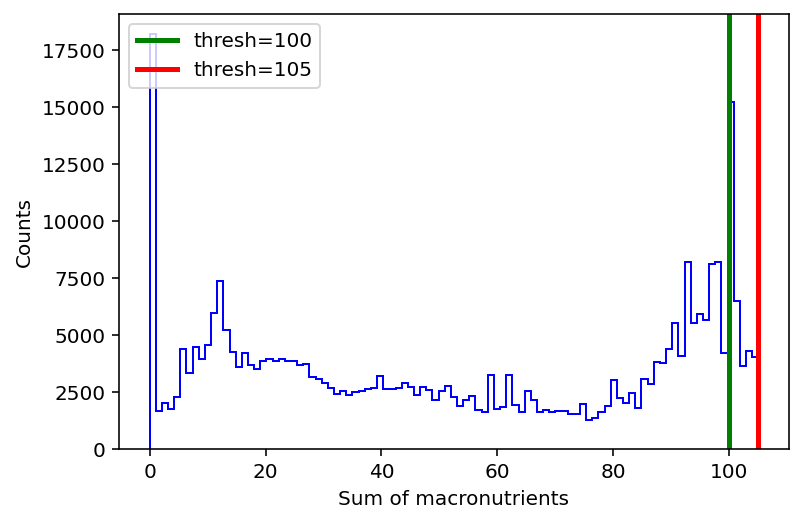

In [76]:
# Replot sum of macronutrients

bins = np.linspace(0,df1[['protein_per_hundred','fat_per_hundred', 'carbohydrates_per_hundred', 'salt_per_hundred','fiber_per_hundred']].sum(axis=1).max(),100)
plt.hist(df1[['protein_per_hundred','fat_per_hundred', 'carbohydrates_per_hundred', 'salt_per_hundred','fiber_per_hundred']].sum(axis=1),
        bins = bins, color='blue', histtype=u'step', label=None);
plt.axvline(x=100, ymin=0, ymax=len(df), c='green',label=f'thresh={100}', lw=2.5);
plt.axvline(x=105, ymin=0, ymax=len(df), c='red',label=f'thresh={105}', lw=2.5);
plt.xlabel('Sum of macronutrients');
plt.ylabel('Counts');
plt.legend();

#### The alcohol column

It looks fine.

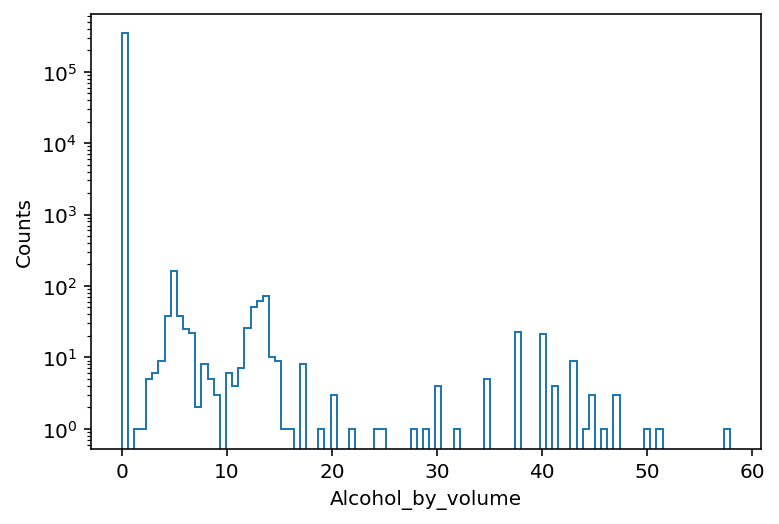

In [77]:
bins = np.linspace(0,df1['alcohol_by_volume'].max(),100)

plt.hist(df1['alcohol_by_volume'],bins=bins, histtype=u'step');
plt.yscale('log')
plt.xlabel('Alcohol_by_volume');
plt.ylabel('Counts');

In [78]:
# Let's have a look at a few products with alcohol content

df1.loc[df1['alcohol_by_volume']>0,['product_name','alcohol_by_volume','barcode']].sample(10)

,product_name,alcohol_by_volume,barcode
7798,appenzeller alpenbitter,29.00,7610082001005
7659,maison centenaire rum black head,37.50,3014400197748
7752,feldschlösschen - stark,7.00,76129384
22583,cave des coteaux - neuchâtel 2017,11.50,7612150111715
7644,tanqueray london dry gin,43.10,5000281015248
14437,oeil de perdrix,13.35,7610029012767
24779,dent blanche white bière,4.30,4099200417868
8296,"rioja, azabache, crianza 2013",14.00,8423513000718
22091,"nebuleuse - überweiss, hefeweizen",5.50,2099438020221
7628,trojka orange vodka liqueur,17.00,7617700591900


### Task B.4: Outliers

> After completing the previous tasks, you should have removed recording errors from the columns with the `per_hundred` suffix in their names. However, you may notice that some of these columns still contain "extreme" values, which are distinct from the rest of the data points. Your goal is to pick a few variables from the `per_hundred` list and address outliers. It would be best to work with the variables you will use in tasks C and F.

So, far, we removed recording errors by comparing the values in the `*_per_hundred` columns with upper thresholds.

However, some columns seem to still have some strange values. Especially the columns whose units are in mg, µg and IU. I would like to explore what z-scores flag as outliers in these columns.  

In [79]:
# Create list of columns with units that are mg, µg or IU

nutrient_to_units_df = pd.DataFrame({'column_name':nutrient_to_units_d.keys(),'units':nutrient_to_units_d.values()})
cols_boxplots = list(nutrient_to_units_df.loc[(nutrient_to_units_df['units'] == 'mg') | 
                                              (nutrient_to_units_df['units'] == 'µg') | 
                                              (nutrient_to_units_df['units'] == 'IU'),'column_name'])

print(cols_boxplots)

['calcium_per_hundred', 'cholesterol_per_hundred', 'copper_cu_per_hundred', 'folate_total_per_hundred', 'folic_acid_per_hundred', 'iron_per_hundred', 'magnesium_per_hundred', 'manganese_mn_per_hundred', 'phosphorus_per_hundred', 'potassium_k_per_hundred', 'vitamin_a_iu_per_hundred', 'vitamin_b12_cobalamin_per_hundred', 'vitamin_b1_thiamin_per_hundred', 'vitamin_b2_riboflavin_per_hundred', 'vitamin_b3_niacin_per_hundred', 'vitamin_b5_panthothenic_acid_per_hundred', 'vitamin_b6_pyridoxin_per_hundred', 'vitamin_c_ascorbic_acid_per_hundred', 'vitamin_d_d2_d3_international_units_per_hundred', 'zinc_per_hundred']


Z-scores expect features with distributions that are close to the normal distribution. The majority of the columns in the `cols_boxplots` have very skewed distributions. Therefore, I will transform these columns either using the `log1p` before computing z-scores.

I will also remove samples with zero values as these can affect the mean and std of the population.

In [80]:
# Create a copy of df1

df2 = df1.copy()

Data shape before removing outliers: (343671, 97)

Removed 59 outliers in calcium_per_hundred
Removed 165 outliers in cholesterol_per_hundred
Removed 4 outliers in copper_cu_per_hundred
Removed 4 outliers in folate_total_per_hundred
Removed 8 outliers in folic_acid_per_hundred
Removed 893 outliers in iron_per_hundred
Removed 4 outliers in magnesium_per_hundred
Removed 23 outliers in manganese_mn_per_hundred
Removed 6 outliers in phosphorus_per_hundred
Removed 274 outliers in potassium_k_per_hundred
Removed 139 outliers in vitamin_a_iu_per_hundred
Removed 81 outliers in vitamin_b12_cobalamin_per_hundred
Removed 62 outliers in vitamin_b1_thiamin_per_hundred
Removed 93 outliers in vitamin_b2_riboflavin_per_hundred
Removed 81 outliers in vitamin_b3_niacin_per_hundred
Removed 51 outliers in vitamin_b5_panthothenic_acid_per_hundred
Removed 108 outliers in vitamin_b6_pyridoxin_per_hundred
Removed 209 outliers in vitamin_c_ascorbic_acid_per_hundred
Removed 9 outliers in vitamin_d_d2_d3_interna

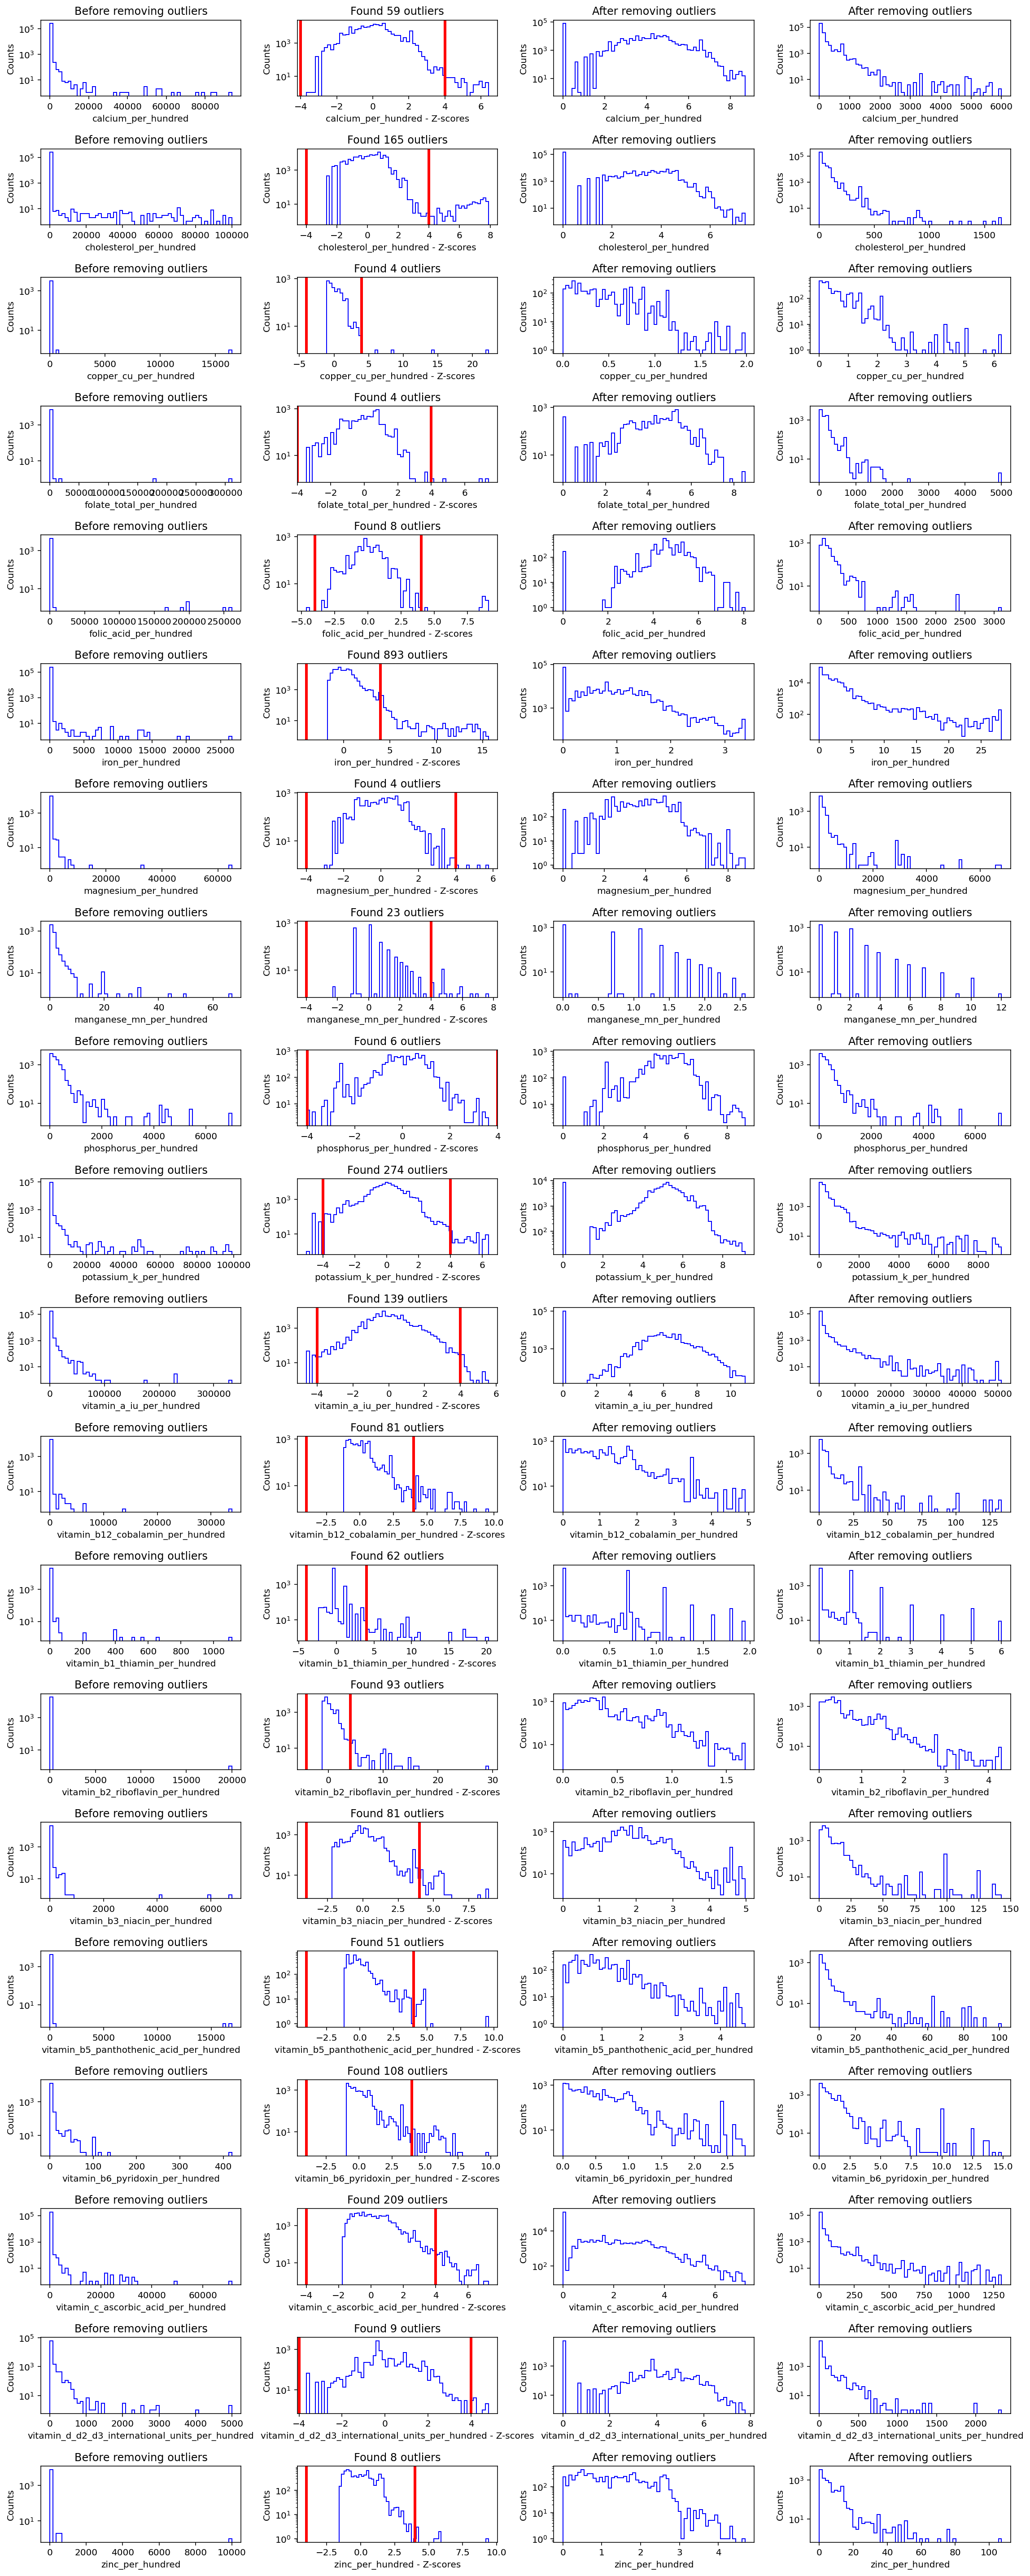

In [81]:
fig, axes = plt.subplots(20,4,figsize=(16,20*2))

thresh = 4

print('Data shape before removing outliers: {}\n'.format(df2.shape))

for i, c in enumerate(cols_boxplots):
        
    # Plot distributions with outliers
    axes[i,0].hist(df2[c], bins=60, color='blue', histtype=u'step')
    axes[i,0].set_yscale('log')
    axes[i,0].set_ylabel('Counts')
    axes[i,0].set_xlabel(c)
    axes[i,0].set_title('Before removing outliers')
    
    # OUTLIERS
    
    # Adress skewness
    df2[c] = np.log1p(df2[c])
    
    # Remove zero subpopulation
    df_tmp = df2.loc[df2[c]>0].copy()  
    
    # z-scores
    # Count outliers
    outliers = (np.abs(zscore(df_tmp[c])) > thresh).sum()
    
    # Plot z-scores                 
    axes[i,1].hist(zscore(df_tmp[c]), bins=60, color='blue', histtype=u'step')
    axes[i,1].set_yscale('log')
    axes[i,1].set_ylabel('Counts')
    axes[i,1].set_xlabel('{} - Z-scores'.format(c))
    axes[i,1].set_title('Found {} outliers'.format(outliers))
    for z_lim in [-thresh, thresh]:
        axes[i,1].axvline(x = z_lim, ymin=0, ymax=np.log(100000),color='red',lw=3)
    
    # Replace outliers in df2 with np.nan
    if outliers != 0:
        df2.loc[df_tmp[(np.abs(zscore(df_tmp[c])) > thresh)].index, c] = np.nan
        print('Removed {} outliers in {}'.format(outliers, c))
     
    # Plot distributions after removing outliers
    axes[i,2].hist(df2[c], bins=60, color='blue', histtype=u'step')
    axes[i,2].set_yscale('log')
    axes[i,2].set_ylabel('Counts')
    axes[i,2].set_xlabel(c)
    axes[i,2].set_title('After removing outliers')
    
    # Invert transformations

    df2[c] = np.expm1(df2[c])

    # Plot distributions after removing outliers
    axes[i,3].hist(df2[c], bins=60, color='blue', histtype=u'step')
    axes[i,3].set_yscale('log')
    axes[i,3].set_ylabel('Counts')
    axes[i,3].set_xlabel(c)
    axes[i,3].set_title('After removing outliers')

print('\nData shape after removing outliers: {}\n'.format(df2.shape))

plt.tight_layout()

#### Sample distribution by the country

In [82]:
100*df2['country'].value_counts(normalize=True)

US    91.942294
CH     7.674782
DE     0.311344
IT     0.046556
FR     0.024442
AT     0.000291
UK     0.000291
Name: country, dtype: float64

In [83]:
# Drop UK and AT countries

df2 = df2.loc[~((df2['country'] == 'UK')| (df2['country'] == 'AT')),:].copy()

In [84]:
# Export cleaned data (keeping only a few columns of interest)

cols_to_keep = [c for c in df2.columns if 'per_portion' not in c]

df2[cols_to_keep].to_pickle("./data/cleaned_data.pkl",compression='zip')